In [1]:
# Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, re, string, os
import gensim
import sent2vec
#import spacy, glove, fastText

from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from scipy import linalg, mat, dot
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.wrappers import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Train models using billion words corpus data (implement once)

In [ ]:
# Save UTF-8 version of text corpus for training

billwords_raw = open("/project/1-billion-word-language-modeling-benchmark-r13output.tar", "r", encoding="ISO-8859-1")
billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'w')

translator = str.maketrans("", "", string.punctuation)

for i, line in enumerate(billwords_raw):
    if i==0:
        pos = line.find("While")
        line = line[pos:]
    if '\0' in line:
        line = line.replace('\0', '')
        
    line = line.translate(translator)
    line = line.lower().strip()
    billwords_clean.write(line)
    billwords_clean.write('\n')                

billwords_raw.close()
billwords_clean.close()

In [ ]:
if '\0' in open('/project/paragraph-vectors/data/billwords_preprocessed.csv').read():
    print("you have null bytes in your input file")
else:
    print ("you don't")

In [ ]:
# Save CSV version of text corpus for training

billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'r')
billwords_csv = open('/project/paragraph-vectors/data/billwords_preprocessed.csv', 'w')

billwords_csv.write('text')
billwords_csv.write('\n')

translator = str.maketrans("", "", string.punctuation)

for line in billwords_clean:
    billwords_csv.write(line)
    billwords_csv.write('\n')

billwords_clean.close()
billwords_csv.close()

In [ ]:
# Save CSV version of text corpus for training

billwords_clean = open('/project/billion-words-dataset/billwords_preprocessed.txt', 'r')
billwords_sample = open('/project/sample_billwords/billwords_sample.txt', 'w')

translator = str.maketrans("", "", string.punctuation)

for i, line in enumerate(billwords_clean):
    if i == 25000000:
        break
    if '\0' in line:
        line = line.replace('\0', '')
    line = line.translate(translator)
    line = line.lower().strip()
    billwords_sample.write(line)
    billwords_sample.write('\n')

billwords_clean.close()
billwords_sample.close()

In [ ]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            translator = str.maketrans("", "", string.punctuation)
            for line in open(os.path.join(self.dirname, fname)):
                line = line.translate(translator)
                line = line.lower().strip()
                yield line.split()

# Assign documents to directory of dataset for training
documents = MySentences("/project/billion_words_dataset")

In [ ]:
# Train word2vec models

modelwd_cbow = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, alpha=0.025, sg=0)
modelwd_sg = Word2Vec(documents, size=300, window=5, min_count=5, workers=20, negative=5, alpha=0.025, sg=1)
#modelwd_train.train(documents, total_examples=len(documents), epochs=20)

In [ ]:
# Save word2vec models

modelwd_cbow.wv.save_word2vec_format('modelwd_cbow.bin', binary=True)
modelwd_sg.wv.save_word2vec_format('modelwd_sg.bin', binary=True)

In [ ]:
# Train GloVe model using dataset assigned to documents
documents = MySentences("/project/billion_words_dataset")

corpus = Corpus()
corpus.fit(documents, window=5)
 
modelgl_train = Glove(no_components=300, learning_rate=0.05)

# Train model with epochs
modelgl_train.fit(corpus.matrix, epochs=5, no_threads=20, verbose=True)

# Add word embeddings to corpus dictionary
modelgl_train.add_dictionary(corpus.dictionary)

# Save model
modelgl_train.save('modelgl_train.txt')

In [ ]:
# Run fastText models in Terminal

./fasttext skipgram -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr 0.025 -output modelft_sg

./fasttext cbow -input billwords_preprocessed.txt -dim 300 -thread 20 -minCount 5 -neg 5 -ws 5 -lr 0.025 -output modelft_cbow

In [ ]:
# Run sent2vec models in Terminal

./fasttext sent2vec -input billwords_preprocessed.txt -output modelsn_uni -minCount 5 -dim 300 -epoch 5 -lr 0.2 -wordNgrams 1 -loss ns -neg 5 -thread 20

./fasttext sent2vec -input billwords_preprocessed.txt -output modelsn_bi -minCount 5 -dim 300 -epoch 5 -lr 0.2 -wordNgrams 2 -loss ns -neg 5 -thread 20

In [ ]:
# python train.py start --data_file_name 'billwords_preprocessed.csv' --num_epochs 5 --batch_size 32 --num_noise_words 2 --vec_dim 300 --lr 0.025 --context_size 5 --model_ver 'dm' --num_workers 20

In [ ]:
def create_tagged_documents(sentences):
    
    '''Gives numerical tags to documents in a list'''
    
    docs_list = create_docs_list(sentences)
    
    tagged_docs = []
    for i, doc in enumerate(docs_list):
        tagged_docs.append(TaggedDocument(words=doc.split(), tags=[i]))
    
    return docs_list, tagged_docs

In [ ]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
    
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for i, line in enumerate(open(os.path.join(self.dirname, fname))):
                yield TaggedDocument(words=line.split(), tags=[i])

In [ ]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
        
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])

In [ ]:
# Assign documents to directory of dataset for training

tagged_docs = MyDocuments("billwords_preprocessed.txt")
#tagged_docs = LabeledLineSentence("/project/sample-billwords/billwords_sample.txt")
#modeldc_dm = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=100, alpha=0.025, min_alpha=0.025, negative=5, dm=1, dbow_words=0)

In [ ]:
def train_doc2vec_model(tagged_docs, dm, dbow_words):
    
    '''Train a different Doc2Vec model using specific parameters'''
    
    model = Doc2Vec(tagged_docs, vector_size=300, window=5, min_count=5, workers=100, alpha=0.025, min_alpha=0.025, 
                     negative=5, dm=dm, dbow_words=dbow_words)
    
    return model

In [ ]:
# Implementation

modeldc_dm = train_doc2vec_model(tagged_docs, dm=1, dbow_words=0)
print('completed')
modeldc_dbow0 = train_doc2vec_model(tagged_docs, dm=0, dbow_words=0)
print('completed')
modeldc_dbow1 = train_doc2vec_model(tagged_docs, dm=0, dbow_words=1)
print('completed')

In [ ]:
# Save trained doc2vec models

modeldc_dm.save('modeldc_dm.doc2vec')
modeldc_dbow0.save('modeldc_dbow0.doc2vec')
modeldc_dbow1.save('modeldc_dbow1.doc2vec')

## Data preparation and munging

In [2]:
# Load datasets

sick = open("SICK.txt", "r")
msr1 = open("msr_train.txt", "r", encoding="utf-8")
msr2 = open("msr_test.txt", "r", encoding="utf-8")
#ppdb = open("ppdb-2.0-l-all", "r")

In [3]:
def read_text_file(file):
    
    '''Reads lines in file and appends to a corpus list'''
    
    corpus = []
    for i, line in enumerate(file):
        if i==0:
            continue
        else:
            corpus.append(line)
    
    return corpus

In [4]:
def read_more_files(file1, file2=None):
    
    '''Reads lines in two files and appends them to a corpus list'''
    
    if file2==None:
        corpus = read_text_file(file1)
        
    else:
        corpus1 = read_text_file(file1)
        corpus2 = read_text_file(file2)
        corpus = corpus1 + corpus2
    
    print(len(corpus))
    return corpus   

In [5]:
# Implementation

sick_corpus = read_more_files(sick)
sick_corpus

9840


['1\tA group of kids is playing in a yard and an old man is standing in the background\tA group of boys in a yard is playing and a man is standing in the background\tNEUTRAL\t4.5\tA_neutral_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '2\tA group of children is playing in the house and there is no man standing in the background\tA group of kids is playing in a yard and an old man is standing in the background\tNEUTRAL\t3.2\tA_contradicts_B\tB_neutral_A\tA group of children playing in a yard, a man in the background.\tA group of children playing in a yard, a man in the background.\tFLICKR\tFLICKR\tTRAIN\n',
 '3\tThe young boys are playing outdoors and the man is smiling nearby\tThe kids are playing outdoors near a man with a smile\tENTAILMENT\t4.7\tA_entails_B\tB_entails_A\tThe children are playing outdoors, while a man smiles nearby.\tThe children are playing 

In [6]:
# Implementation

msr_corpus = read_more_files(msr1, msr2)
msr_corpus

5801


['1\t702876\t702977\tAmrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.\tReferring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.\n',
 "0\t2108705\t2108831\tYucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.\tYucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.\n",
 "1\t1330381\t1330521\tThey had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.\tOn June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.\n",
 '0\t3344667\t3344648\tAround 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.\tTab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.\n',
 '1\t1236820\t1236712\tThe stock rose $2.11, or about 11 percent, to close Friday at $21.51 on

In [7]:
def extract_sentences_scores(corpus):
    
    '''Creates a list of sentence pairs omitting punctuation and a list of similarity scores'''
    
    sentences, scores = [], []
    for line in corpus:
        words = line.split('\t')
        
        for i, word in enumerate(words):
            try:
                int(word[0])
                continue
                
            except:
                sent1 = words[i].lower().strip()
                sent2 = words[i+1].lower().strip()
                
                translator = str.maketrans("", "", string.punctuation)
                sent1 = sent1.translate(translator)
                sent2 = sent2.translate(translator)
                
                sentences.append([sent1, sent2])
                
                if i==1:
                    score = words[4]
                    scores.append(float(score))
                
                elif i==3:
                    score = words[0]
                    scores.append(float(score))
                
                break
            
            else: continue
        
    return sentences, scores

In [8]:
# Implementation

sick_sentences, sick_scores = extract_sentences_scores(sick_corpus)
msr_sentences, msr_scores = extract_sentences_scores(msr_corpus)

In [ ]:
sick_sentences

In [ ]:
msr_sentences

## Stemming, Lemmatization, Filtering stopwords

In [9]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

def stemming_words(sentences):
    
    '''Stems words in sentences using Porter Stemmer'''
    
    porter_stemmer = PorterStemmer()
    
    sentences_stem = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                sent_new.append(porter_stemmer.stem(word))
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_stem.append(pair_new)
    
    return sentences_stem
        

In [10]:
porter_stemmer = PorterStemmer()
porter_stemmer.stem('organisationally')

'organis'

In [11]:
# Implementation

sick_sentences_stem = stemming_words(sick_sentences)
msr_sentences_stem = stemming_words(msr_sentences)

In [ ]:
sick_sentences_stem

In [ ]:
msr_sentences_stem

In [12]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    '''Gets POS tags from Wordnet'''
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''
    

In [13]:
from nltk import pos_tag

def pos_tagging(sentences):
    
    '''Part-of-Speech tagging using Wordnet treebank tags'''
    
    sentences_pos = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            tagged = pos_tag(words)
            for token, tag in tagged:
                wntag = get_wordnet_pos(tag)
                wordset = (token, wntag)
                sent_new.append(wordset)
            pair_new.append(sent_new) 
        sentences_pos.append(pair_new)
    
    return sentences_pos

In [14]:
# Implementation

sick_sentences_pos = pos_tagging(sick_sentences)
msr_sentences_pos = pos_tagging(msr_sentences)

In [ ]:
sick_sentences_pos

In [ ]:
msr_sentences_pos

In [15]:
from nltk.stem.wordnet import WordNetLemmatizer

def lemmatizing_words(sentences):
    
    '''Lemmatizes words in sentences that are POS-tagged'''
    
    sentences_pos = pos_tagging(sentences)
    
    lemmatizer = WordNetLemmatizer()
    
    sentences_lemma = []
    for pair in sentences_pos:
        pair_new = []
        for sent in pair:
            sent_new = []
            for wordset in sent:
                try:
                    sent_new.append(lemmatizer.lemmatize(wordset[0], pos=wordset[1]))
                except:
                    sent_new.append(wordset[0])
                doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        sentences_lemma.append(pair_new)
    
    return sentences_lemma

In [17]:
# Implementation

sick_sentences_lemma = lemmatizing_words(sick_sentences)
msr_sentences_lemma = lemmatizing_words(msr_sentences)

In [ ]:
sick_sentences_lemma

In [ ]:
msr_sentences_lemma

In [18]:
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
    
def remove_stopwords(sentences, stopwords):
    
    '''Removes English stopwords from sentences'''
    
    filtered_words = []
    for pair in sentences:
        pair_new = []
        for sent in pair:
            sent_new = []
            words = word_tokenize(sent)
            for word in words:
                if word not in stopwords:
                    sent_new.append(word)
            doc = ' '.join(sent_new)
            pair_new.append(doc)
        
        filtered_words.append(pair_new)
    
    return filtered_words

In [19]:
# Implementation

sick_filtered = remove_stopwords(sick_sentences, stopwords)
msr_filtered = remove_stopwords(msr_sentences, stopwords)

sick_stemstw = remove_stopwords(sick_sentences_stem, stopwords)
msr_stemstw = remove_stopwords(msr_sentences_stem, stopwords)

sick_lemstw = remove_stopwords(sick_sentences_lemma, stopwords)
msr_lemstw = remove_stopwords(msr_sentences_lemma, stopwords)

In [ ]:
sick_filtered

In [ ]:
msr_filtered

## Functions for model evaluation

In [20]:
def convert_scores_to_binary(scores_list, threshold):
    
    '''Converts a percentage accuracy score to either a 0 or a 1'''
    
    bin_scores = []
    for score in scores_list:
        if score < threshold:
            bin_scores.append(0)
        else:
            bin_scores.append(1)
    
    return bin_scores

msr_scores = convert_scores_to_binary(msr_scores, 0.7)

In [21]:
def create_correlation_tables(df):
    
    '''Creates tables showing Pearson's and Spearman's correlations'''
    
    
    display(df.corr(method='pearson'))
    print("Pearson's correlation")
    
    display(df.corr(method='spearman'))
    print("Spearman's correlation")
    
    return

In [22]:
def create_confusion_matrices(df):
    
    '''Creates confusion matrices with accuracy and F1 scores'''
    
    for column in df:
        cf = pd.DataFrame(confusion_matrix(df['Similarity'], df[column]), 
                          columns=['Pred 0', 'Pred 1'], index=['True 0', 'True 1'])
        cf.index.name = column
        display(cf)
        
        acc = accuracy_score(df['Similarity'], df[column])
        f1 = f1_score(df['Similarity'], df[column])
        print('Accuracy:', round(acc, 6))
        print('F1 score:', round(f1, 6))
        
    return

In [23]:
def get_first_row(df):
    
    '''Gets first row of correlation matrix tables'''
    
    df_pearson = pd.DataFrame(df.corr(method='pearson').iloc[0])
    
    df_spearman = pd.DataFrame(df.corr(method='spearman').iloc[0])
    df_corr = pd.concat([df_pearson, df_spearman], axis=1, sort=False)
    df_corr.columns = ['Pearson', 'Spearman']
    df_corr.drop('Relatedness', axis=0, inplace=True)
    df_corr.index.name = 'Correlation'
    display(df_corr)
    
    return

In [24]:
def show_class_scores(df):
    
    '''Creates table of accuracy and F1 scores'''
    
    scores_dict = {}
    
    for column in df:
        acc = accuracy_score(df['Similarity'], df[column])
        f1 = f1_score(df['Similarity'], df[column])
        
        if acc==1:
            continue
            
        scores_dict[column] = [acc, f1]
    
    df_scores = pd.DataFrame.from_dict(scores_dict).T
    df_scores = df_scores.rename(columns={0: 'Accuracy', 1: 'F1 score'})
    df_scores.index.name = 'Classification'
    
    return df_scores

In [25]:
def all_accuracy_thresholds(scores_list):
    
    '''Displays accuracy and F1-scores for a model scores list at all threshold levels at each 0.01 step'''
    
    accuracy_df = pd.DataFrame()
    
    for threshold in range(0, 101, 1):
        
        thres = threshold/100
        accuracy_list = []
        bin_scores = convert_scores_to_binary(scores_list, thres)
        
        accuracy_df[thres] = bin_scores
        
    accuracy_df['Similarity'] = msr_scores
    scores_df = show_class_scores(accuracy_df)
        
    return scores_df.loc[scores_df['Accuracy'].idxmax()]

In [26]:
def create_ROC_AUC(scores_list, title):
    
    '''Plots ROC curve with AUC score'''

    plt.figure(figsize=(6, 4))
    # ROC curve; AUC score
    fpr, tpr, thresholds = roc_curve(msr_scores, scores_list, pos_label=1)
    roc_auc_dt = auc(fpr, tpr)

    plt.title('ROC Curve - ' + title)
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.4f'% roc_auc_dt)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

## Bag-of-Words model

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def run_bow_model(sentences):
    
    '''Creates BoW model and calculates cosine similarity of each sentence pair'''
    
    scores_list = []
    ngrams = [(1, 1), (1, 2)]
    
    for tup in ngrams:
        count_vec = CountVectorizer(stop_words="english", analyzer='word', ngram_range=tup, 
                                   max_df=1.0, min_df=1, max_features=None)
        
        bow_scores = []  
        for pair in sentences:
            bow_model = count_vec.fit_transform(pair).toarray()
            cos_sim = cosine_similarity(bow_model[0,:].reshape(1,-1), bow_model[1,:].reshape(1, -1))
            bow_scores.append(float(cos_sim))
        
        scores_list.append(bow_scores)
        
    
    return scores_list

In [28]:
# Implementation

sick_bow_scores = run_bow_model(sick_sentences)
msr_bow_scores = run_bow_model(msr_sentences)

sick_bow_stem_scores = run_bow_model(sick_sentences_stem)
msr_bow_stem_scores = run_bow_model(msr_sentences_stem)

sick_bow_lem_scores = run_bow_model(sick_sentences_lemma)
msr_bow_lem_scores = run_bow_model(msr_sentences_lemma)

sick_bow_stw_scores = run_bow_model(sick_filtered)
msr_bow_stw_scores = run_bow_model(msr_filtered)

sick_bow_stemstw_scores = run_bow_model(sick_stemstw)
msr_bow_stemstw_scores = run_bow_model(msr_stemstw)

sick_bow_lemstw_scores = run_bow_model(sick_lemstw)
msr_bow_lemstw_scores = run_bow_model(msr_lemstw)

In [ ]:
sick_bow_scores

In [ ]:
msr_bow_scores

In [29]:
df_sick_bow = pd.DataFrame({'Relatedness': sick_scores, 'BoW_uni': sick_bow_scores[0], 'BoW_bi': sick_bow_scores[1],
                            'BoW_stem_uni': sick_bow_stem_scores[0], 'BoW_stem_bi': sick_bow_stem_scores[1],
                            'BoW_lemma_uni': sick_bow_lem_scores[0], 'BoW_lemma_bi': sick_bow_lem_scores[1], 
                            'BoW_stw_uni': sick_bow_stw_scores[0], 'BoW_stw_bi': sick_bow_stw_scores[1],
                            'BoW_stemstw_uni': sick_bow_stemstw_scores[0], 'BoW_stemstw_bi': sick_bow_stemstw_scores[1],
                            'BoW_lemstw_uni': sick_bow_lemstw_scores[0], 'BoW_lemstw_bi': sick_bow_lemstw_scores[1]})
df_sick_bow

,Relatedness,BoW_uni,BoW_bi,BoW_stem_uni,BoW_stem_bi,BoW_lemma_uni,BoW_lemma_bi,BoW_stw_uni,BoW_stw_bi,BoW_stemstw_uni,BoW_stemstw_bi,BoW_lemstw_uni,BoW_lemstw_bi
0,4.500,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892,0.801784,0.572892
1,3.200,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280,0.668153,0.501280
2,4.700,0.462910,0.334497,0.617213,0.501745,0.617213,0.501745,0.462910,0.334497,0.617213,0.501745,0.617213,0.501745
3,3.600,0.676123,0.647150,0.845154,0.832050,0.676123,0.554700,0.676123,0.647150,0.845154,0.832050,0.676123,0.554700
4,3.400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400,0.433013,0.311400
5,3.300,0.316228,0.172133,0.316228,0.172133,0.158114,0.086066,0.316228,0.172133,0.316228,0.172133,0.158114,0.086066
6,3.700,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769,0.428571,0.230769
7,3.000,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846,0.285714,0.153846
8,3.700,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223,0.267261,0.143223
9,4.900,0.925820,0.836242,0.935414,0.859338,0.925820,0.836242,0.925820,0.836242,0.935414,0.859338,0.925820,0.836242


In [30]:
# Implementation

get_first_row(df_sick_bow)

,Pearson,Spearman
Correlation,,
BoW_uni,0.614472,0.556966
BoW_bi,0.545892,0.548808
BoW_stem_uni,0.638548,0.574967
BoW_stem_bi,0.568393,0.560434
BoW_lemma_uni,0.640159,0.581296
BoW_lemma_bi,0.569404,0.563330
BoW_stw_uni,0.614599,0.557103
BoW_stw_bi,0.545688,0.548688
BoW_stemstw_uni,0.638570,0.575003


In [31]:
for i in range(0, 2):
    print('\nORIG')
    print(all_accuracy_thresholds(msr_bow_scores[i]))
    print('\nSTEM')
    print(all_accuracy_thresholds(msr_bow_stem_scores[i]))
    print('\nLEM')
    print(all_accuracy_thresholds(msr_bow_lem_scores[i]))
    print('\nSTW')
    print(all_accuracy_thresholds(msr_bow_stw_scores[i]))
    print('\nSTEMSW')
    print(all_accuracy_thresholds(msr_bow_stemstw_scores[i]))
    print('\nLEMSW')
    print(all_accuracy_thresholds(msr_bow_lemstw_scores[i]))
    print('\nuni/bi')


ORIG
Accuracy    0.702637
F1 score    0.795640
Name: 0.53, dtype: float64

STEM
Accuracy    0.713153
F1 score    0.807229
Name: 0.53, dtype: float64

LEM
Accuracy    0.705396
F1 score    0.800839
Name: 0.53, dtype: float64

STW
Accuracy    0.702465
F1 score    0.795595
Name: 0.53, dtype: float64

STEMSW
Accuracy    0.712808
F1 score    0.806997
Name: 0.53, dtype: float64

LEMSW
Accuracy    0.705568
F1 score    0.801025
Name: 0.53, dtype: float64

uni/bi

ORIG
Accuracy    0.691433
F1 score    0.803124
Name: 0.32, dtype: float64

STEM
Accuracy    0.695742
F1 score    0.809375
Name: 0.31, dtype: float64

LEM
Accuracy    0.694191
F1 score    0.805397
Name: 0.33, dtype: float64

STW
Accuracy    0.691605
F1 score    0.803212
Name: 0.32, dtype: float64

STEMSW
Accuracy    0.695570
F1 score    0.809246
Name: 0.31, dtype: float64

LEMSW
Accuracy    0.694535
F1 score    0.805616
Name: 0.33, dtype: float64

uni/bi


In [32]:
# Convert scores to binary

msr_bow_binscores, msr_bow_stem_binscores, msr_bow_lem_binscores = [], [], []
msr_bow_stw_binscores, msr_bow_stemstw_binscores, msr_bow_lemstw_binscores = [], [], []

threshold1 = [0.53, 0.32]
threshold2 = [0.53, 0.31]
threshold3 = [0.53, 0.33]
threshold4 = [0.53, 0.32]
threshold5 = [0.53, 0.31]
threshold6 = [0.53, 0.33]

for i in range(0, 2):
    msr_bow_binscores.append(convert_scores_to_binary(msr_bow_scores[i], threshold1[i]))
    msr_bow_stem_binscores.append(convert_scores_to_binary(msr_bow_stem_scores[i], threshold2[i]))
    msr_bow_lem_binscores.append(convert_scores_to_binary(msr_bow_lem_scores[i], threshold3[i]))
    msr_bow_stw_binscores.append(convert_scores_to_binary(msr_bow_stw_scores[i], threshold4[i]))
    msr_bow_stemstw_binscores.append(convert_scores_to_binary(msr_bow_stemstw_scores[i], threshold5[i]))
    msr_bow_lemstw_binscores.append(convert_scores_to_binary(msr_bow_lemstw_scores[i], threshold6[i]))

In [33]:
df_msr_bow = pd.DataFrame({'Similarity': msr_scores, 'BoW_uni_0.53': msr_bow_binscores[0], 'BoW_bi_0.32': msr_bow_binscores[1],
                            'BoW_stem_uni_0.53': msr_bow_stem_binscores[0], 'BoW_stem_bi_0.31': msr_bow_stem_binscores[1],
                            'BoW_lemma_uni_0.53': msr_bow_lem_binscores[0], 'BoW_lemma_bi_0.33': msr_bow_lem_binscores[1], 
                            'BoW_stw_uni_0.53': msr_bow_stw_binscores[0], 'BoW_stw_bi_0.32': msr_bow_stw_binscores[1],
                            'BoW_stemstw_uni_0.53': msr_bow_stemstw_binscores[0], 'BoW_stemstw_bi_0.31': msr_bow_stemstw_binscores[1],
                            'BoW_lemstw_uni_0.53': msr_bow_lemstw_binscores[0], 'BoW_lemstw_bi_0.33': msr_bow_lemstw_binscores[1]})
df_msr_bow

,Similarity,BoW_uni_0.53,BoW_bi_0.32,BoW_stem_uni_0.53,BoW_stem_bi_0.31,BoW_lemma_uni_0.53,BoW_lemma_bi_0.33,BoW_stw_uni_0.53,BoW_stw_bi_0.32,BoW_stemstw_uni_0.53,BoW_stemstw_bi_0.31,BoW_lemstw_uni_0.53,BoW_lemstw_bi_0.33
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,1,1,0,0,0,0,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1


In [34]:
# Confusion matrices

create_confusion_matrices(df_msr_bow)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
BoW_uni_0.53,,
True 0,718,1183
True 1,542,3358


Accuracy: 0.702637
F1 score: 0.79564


,Pred 0,Pred 1
BoW_bi_0.32,,
True 0,360,1541
True 1,249,3651


Accuracy: 0.691433
F1 score: 0.803124


,Pred 0,Pred 1
BoW_stem_uni_0.53,,
True 0,653,1248
True 1,416,3484


Accuracy: 0.713153
F1 score: 0.807229


,Pred 0,Pred 1
BoW_stem_bi_0.31,,
True 0,289,1612
True 1,153,3747


Accuracy: 0.695742
F1 score: 0.809375


,Pred 0,Pred 1
BoW_lemma_uni_0.53,,
True 0,656,1245
True 1,464,3436


Accuracy: 0.705396
F1 score: 0.800839


,Pred 0,Pred 1
BoW_lemma_bi_0.33,,
True 0,356,1545
True 1,229,3671


Accuracy: 0.694191
F1 score: 0.805397


,Pred 0,Pred 1
BoW_stw_uni_0.53,,
True 0,716,1185
True 1,541,3359


Accuracy: 0.702465
F1 score: 0.795595


,Pred 0,Pred 1
BoW_stw_bi_0.32,,
True 0,361,1540
True 1,249,3651


Accuracy: 0.691605
F1 score: 0.803212


,Pred 0,Pred 1
BoW_stemstw_uni_0.53,,
True 0,652,1249
True 1,417,3483


Accuracy: 0.712808
F1 score: 0.806997


,Pred 0,Pred 1
BoW_stemstw_bi_0.31,,
True 0,289,1612
True 1,154,3746


Accuracy: 0.69557
F1 score: 0.809246


,Pred 0,Pred 1
BoW_lemstw_uni_0.53,,
True 0,655,1246
True 1,462,3438


Accuracy: 0.705568
F1 score: 0.801025


,Pred 0,Pred 1
BoW_lemstw_bi_0.33,,
True 0,357,1544
True 1,228,3672


Accuracy: 0.694535
F1 score: 0.805616


In [35]:
# Implementation

show_class_scores(df_msr_bow)

,Accuracy,F1 score
Classification,,
BoW_uni_0.53,0.702637,0.795640
BoW_bi_0.32,0.691433,0.803124
BoW_stem_uni_0.53,0.713153,0.807229
BoW_stem_bi_0.31,0.695742,0.809375
BoW_lemma_uni_0.53,0.705396,0.800839
BoW_lemma_bi_0.33,0.694191,0.805397
BoW_stw_uni_0.53,0.702465,0.795595
BoW_stw_bi_0.32,0.691605,0.803212
BoW_stemstw_uni_0.53,0.712808,0.806997


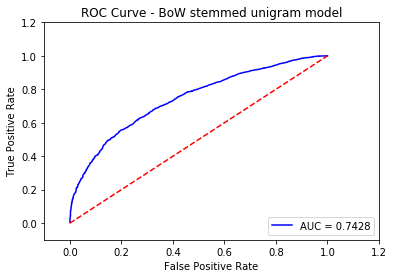

In [36]:
# ROC curve and AUC score

create_ROC_AUC(msr_bow_stem_scores[0], 'BoW stemmed unigram model')

## TF-IDF model

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

def run_tfidf_model(sentences):
    
    '''Creates TF-IDF model and calculates cosine similarity of each sentence pair'''
    
    scores_list = []
    ngrams = [(1, 1), (1, 2)]
    
    for tup in ngrams:
        tfidf_vec = TfidfVectorizer(stop_words="english", analyzer='word', ngram_range=tup, 
                                    max_df=1.0, min_df=1, max_features=None)
    
        tfidf_scores = []
        for pair in sentences:
            tfidf_model = tfidf_vec.fit_transform(pair).toarray()
            cos_sim = cosine_similarity(tfidf_model[0,:].reshape(1,-1), tfidf_model[1,:].reshape(1, -1))
            tfidf_scores.append(float(cos_sim))
            
        scores_list.append(tfidf_scores)
           
    return scores_list

In [38]:
# Implementation

sick_tfidf_scores = run_tfidf_model(sick_sentences)
msr_tfidf_scores = run_tfidf_model(msr_sentences)

sick_tfidf_stem_scores = run_tfidf_model(sick_sentences_stem)
msr_tfidf_stem_scores = run_tfidf_model(msr_sentences_stem)

sick_tfidf_lem_scores = run_tfidf_model(sick_sentences_lemma)
msr_tfidf_lem_scores = run_tfidf_model(msr_sentences_lemma)

sick_tfidf_stw_scores = run_tfidf_model(sick_filtered)
msr_tfidf_stw_scores = run_tfidf_model(msr_filtered)

sick_tfidf_stemstw_scores = run_tfidf_model(sick_stemstw)
msr_tfidf_stemstw_scores = run_tfidf_model(msr_stemstw)

sick_tfidf_lemstw_scores = run_tfidf_model(sick_lemstw)
msr_tfidf_lemstw_scores = run_tfidf_model(msr_lemstw)

In [ ]:
sick_tfidf_scores

In [ ]:
msr_tfidf_scores

In [39]:
df_sick_tfidf = pd.DataFrame({'Relatedness': sick_scores, 'TF-IDF_uni': sick_tfidf_scores[0], 'TF-IDF_bi': sick_tfidf_scores[1],
                            'TF-IDF_stem_uni': sick_tfidf_stem_scores[0], 'TF-IDF_stem_bi': sick_tfidf_stem_scores[1],
                            'TF-IDF_lemma_uni': sick_tfidf_lem_scores[0], 'TF-IDF_lemma_bi': sick_tfidf_lem_scores[1], 
                            'TF-IDF_stw_uni': sick_tfidf_stw_scores[0], 'TF-IDF_stw_bi': sick_tfidf_stw_scores[1],
                            'TF-IDF_stemstw_uni': sick_tfidf_stemstw_scores[0], 'TF-IDF_stemstw_bi': sick_tfidf_stemstw_scores[1],
                            'TF-IDF_lemstw_uni': sick_tfidf_lemstw_scores[0], 'TF-IDF_lemstw_bi': sick_tfidf_lemstw_scores[1]})
df_sick_tfidf

,Relatedness,TF-IDF_uni,TF-IDF_bi,TF-IDF_stem_uni,TF-IDF_stem_bi,TF-IDF_lemma_uni,TF-IDF_lemma_bi,TF-IDF_stw_uni,TF-IDF_stw_bi,TF-IDF_stemstw_uni,TF-IDF_stemstw_bi,TF-IDF_lemstw_uni,TF-IDF_lemstw_bi
0,4.500,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992,0.673521,0.404992
1,3.200,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619,0.505606,0.337619
2,4.700,0.304126,0.203006,0.450268,0.338174,0.450268,0.338174,0.304126,0.203006,0.450268,0.338174,0.450268,0.338174
3,3.600,0.519388,0.487191,0.747407,0.729728,0.519388,0.390186,0.519388,0.487191,0.747407,0.729728,0.519388,0.390186
4,3.400,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771,0.279828,0.186771
5,3.300,0.190874,0.095554,0.190874,0.095554,0.087044,0.045574,0.190874,0.095554,0.190874,0.095554,0.087044,0.045574
6,3.700,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849,0.275196,0.131849
7,3.000,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286,0.168398,0.084286
8,3.700,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040,0.155929,0.078040
9,4.900,0.867364,0.724107,0.883128,0.758156,0.867364,0.724107,0.867364,0.724107,0.883128,0.758156,0.867364,0.724107


In [40]:
# Implementation

get_first_row(df_sick_tfidf)

,Pearson,Spearman
Correlation,,
TF-IDF_uni,0.560429,0.558943
TF-IDF_bi,0.472194,0.548133
TF-IDF_stem_uni,0.588698,0.575866
TF-IDF_stem_bi,0.493539,0.559361
TF-IDF_lemma_uni,0.592724,0.581774
TF-IDF_lemma_bi,0.494923,0.561944
TF-IDF_stw_uni,0.560528,0.559041
TF-IDF_stw_bi,0.471904,0.548098
TF-IDF_stemstw_uni,0.588722,0.575901


In [41]:
for i in range(0, 2):
    print('\nORIG')
    print(all_accuracy_thresholds(msr_tfidf_scores[i]))
    print('\nSTEM')
    print(all_accuracy_thresholds(msr_tfidf_stem_scores[i]))
    print('\nLEM')
    print(all_accuracy_thresholds(msr_tfidf_lem_scores[i]))
    print('\nSTW')
    print(all_accuracy_thresholds(msr_tfidf_stw_scores[i]))
    print('\nSTEMSW')
    print(all_accuracy_thresholds(msr_tfidf_stemstw_scores[i]))
    print('\nLEMSW')
    print(all_accuracy_thresholds(msr_tfidf_lemstw_scores[i]))
    print('\nuni/bi')


ORIG
Accuracy    0.699707
F1 score    0.790423
Name: 0.38, dtype: float64

STEM
Accuracy    0.712808
F1 score    0.808153
Name: 0.36, dtype: float64

LEM
Accuracy    0.704189
F1 score    0.803166
Name: 0.35, dtype: float64

STW
Accuracy    0.698845
F1 score    0.789847
Name: 0.38, dtype: float64

STEMSW
Accuracy    0.712291
F1 score    0.807874
Name: 0.36, dtype: float64

LEMSW
Accuracy    0.704189
F1 score    0.803256
Name: 0.35, dtype: float64

uni/bi

ORIG
Accuracy    0.691950
F1 score    0.802825
Name: 0.2, dtype: float64

STEM
Accuracy    0.695914
F1 score    0.808760
Name: 0.19, dtype: float64

LEM
Accuracy    0.694363
F1 score    0.805656
Name: 0.2, dtype: float64

STW
Accuracy    0.691950
F1 score    0.802825
Name: 0.2, dtype: float64

STEMSW
Accuracy    0.695742
F1 score    0.808631
Name: 0.19, dtype: float64

LEMSW
Accuracy    0.694708
F1 score    0.805875
Name: 0.2, dtype: float64

uni/bi


In [42]:
# Convert scores to binary

msr_tfidf_binscores, msr_tfidf_stem_binscores, msr_tfidf_lem_binscores = [], [], []
msr_tfidf_stw_binscores, msr_tfidf_stemstw_binscores, msr_tfidf_lemstw_binscores = [], [], []

threshold1 = [0.38, 0.20]
threshold2 = [0.36, 0.19]
threshold3 = [0.35, 0.20]
threshold4 = [0.38, 0.20]
threshold5 = [0.36, 0.19]
threshold6 = [0.35, 0.20]

for i in range(0, 2):
    msr_tfidf_binscores.append(convert_scores_to_binary(msr_tfidf_scores[i], threshold1[i]))
    msr_tfidf_stem_binscores.append(convert_scores_to_binary(msr_tfidf_stem_scores[i], threshold2[i]))
    msr_tfidf_lem_binscores.append(convert_scores_to_binary(msr_tfidf_lem_scores[i], threshold3[i]))
    msr_tfidf_stw_binscores.append(convert_scores_to_binary(msr_tfidf_stw_scores[i], threshold4[i]))
    msr_tfidf_stemstw_binscores.append(convert_scores_to_binary(msr_tfidf_stemstw_scores[i], threshold5[i]))
    msr_tfidf_lemstw_binscores.append(convert_scores_to_binary(msr_tfidf_lemstw_scores[i], threshold6[i]))

In [43]:
df_msr_tfidf = pd.DataFrame({'Similarity': msr_scores, 'TF-IDF_uni_0.38': msr_tfidf_binscores[0], 'TF-IDF_bi_0.20': msr_tfidf_binscores[1],
                            'TF-IDF_stem_uni_0.36': msr_tfidf_stem_binscores[0], 'TF-IDF_stem_bi_0.19': msr_tfidf_stem_binscores[1],
                            'TF-IDF_lemma_uni_0.35': msr_tfidf_lem_binscores[0], 'TF-IDF_lemma_bi_0.20': msr_tfidf_lem_binscores[1], 
                            'TF-IDF_stw_uni_0.38': msr_tfidf_stw_binscores[0], 'TF-IDF_stw_bi_0.20': msr_tfidf_stw_binscores[1],
                            'TF-IDF_stemstw_uni_0.36': msr_tfidf_stemstw_binscores[0], 'TF-IDF_stemstw_bi_0.19': msr_tfidf_stemstw_binscores[1],
                            'TF-IDF_lemstw_uni_0.35': msr_tfidf_lemstw_binscores[0], 'TF-IDF_lemstw_bi_0.20': msr_tfidf_lemstw_binscores[1]})
df_msr_tfidf

,Similarity,TF-IDF_uni_0.38,TF-IDF_bi_0.20,TF-IDF_stem_uni_0.36,TF-IDF_stem_bi_0.19,TF-IDF_lemma_uni_0.35,TF-IDF_lemma_bi_0.20,TF-IDF_stw_uni_0.38,TF-IDF_stw_bi_0.20,TF-IDF_stemstw_uni_0.36,TF-IDF_stemstw_bi_0.19,TF-IDF_lemstw_uni_0.35,TF-IDF_lemstw_bi_0.20
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,1,1,0,0,0,0,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1


In [44]:
# Confusion matrices

create_confusion_matrices(df_msr_tfidf)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
TF-IDF_uni_0.38,,
True 0,774,1127
True 1,615,3285


Accuracy: 0.699707
F1 score: 0.790423


,Pred 0,Pred 1
TF-IDF_bi_0.20,,
True 0,376,1525
True 1,262,3638


Accuracy: 0.69195
F1 score: 0.802825


,Pred 0,Pred 1
TF-IDF_stem_uni_0.36,,
True 0,626,1275
True 1,391,3509


Accuracy: 0.712808
F1 score: 0.808153


,Pred 0,Pred 1
TF-IDF_stem_bi_0.19,,
True 0,307,1594
True 1,170,3730


Accuracy: 0.695914
F1 score: 0.80876


,Pred 0,Pred 1
TF-IDF_lemma_uni_0.35,,
True 0,584,1317
True 1,399,3501


Accuracy: 0.704189
F1 score: 0.803166


,Pred 0,Pred 1
TF-IDF_lemma_bi_0.20,,
True 0,353,1548
True 1,225,3675


Accuracy: 0.694363
F1 score: 0.805656


,Pred 0,Pred 1
TF-IDF_stw_uni_0.38,,
True 0,771,1130
True 1,617,3283


Accuracy: 0.698845
F1 score: 0.789847


,Pred 0,Pred 1
TF-IDF_stw_bi_0.20,,
True 0,376,1525
True 1,262,3638


Accuracy: 0.69195
F1 score: 0.802825


,Pred 0,Pred 1
TF-IDF_stemstw_uni_0.36,,
True 0,623,1278
True 1,391,3509


Accuracy: 0.712291
F1 score: 0.807874


,Pred 0,Pred 1
TF-IDF_stemstw_bi_0.19,,
True 0,307,1594
True 1,171,3729


Accuracy: 0.695742
F1 score: 0.808631


,Pred 0,Pred 1
TF-IDF_lemstw_uni_0.35,,
True 0,582,1319
True 1,397,3503


Accuracy: 0.704189
F1 score: 0.803256


,Pred 0,Pred 1
TF-IDF_lemstw_bi_0.20,,
True 0,354,1547
True 1,224,3676


Accuracy: 0.694708
F1 score: 0.805875


In [45]:
# Implementation

show_class_scores(df_msr_tfidf)

,Accuracy,F1 score
Classification,,
TF-IDF_uni_0.38,0.699707,0.790423
TF-IDF_bi_0.20,0.691950,0.802825
TF-IDF_stem_uni_0.36,0.712808,0.808153
TF-IDF_stem_bi_0.19,0.695914,0.808760
TF-IDF_lemma_uni_0.35,0.704189,0.803166
TF-IDF_lemma_bi_0.20,0.694363,0.805656
TF-IDF_stw_uni_0.38,0.698845,0.789847
TF-IDF_stw_bi_0.20,0.691950,0.802825
TF-IDF_stemstw_uni_0.36,0.712291,0.807874


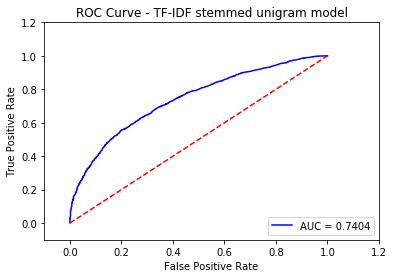

In [46]:
# ROC curve and AUC score

create_ROC_AUC(msr_tfidf_stem_scores[0], 'TF-IDF stemmed unigram model')

## Functions for model execution

In [47]:
def create_words_list(sentences):
    
    '''Creates a list with separate words in each sentence'''
    
    words_list = []

    for pair in sentences:
        pair_new = []
        for sent in pair:
            words = sent.split()
            pair_new.append(words)

        words_list.append(pair_new)
    
    return words_list

In [48]:
# Implementation

sick_words_list = create_words_list(sick_sentences)
msr_words_list = create_words_list(msr_sentences)

sick_stem_words_list = create_words_list(sick_sentences_stem)
msr_stem_words_list = create_words_list(msr_sentences_stem)

sick_lem_words_list = create_words_list(sick_sentences_lemma)
msr_lem_words_list = create_words_list(msr_sentences_lemma)

sick_stw_words_list = create_words_list(sick_filtered)
msr_stw_words_list = create_words_list(msr_filtered)

sick_stemstw_words_list = create_words_list(sick_stemstw)
msr_stemstw_words_list = create_words_list(msr_stemstw)

sick_lemstw_words_list = create_words_list(sick_lemstw)
msr_lemstw_words_list = create_words_list(msr_lemstw)

In [ ]:
sick_words_list

In [ ]:
msr_words_list

In [49]:
def run_gensim_model(words_list, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model[word])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        try:
            cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
            #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        except:
            cos_sim = 0
        
        scores.append(float(cos_sim))
        
    return scores

In [29]:
def run_spacy_model(sentences, model):
    
    '''Runs Word2Vec and GloVe models in SpaCy and computes cosine similarity scores for each sentence pair'''
    
    scores = []
    for pair in sentences:
        token1 = model(pair[0])
        token2 = model(pair[1])
        scores.append(token1.similarity(token2))

    return scores

In [72]:
#from glove import Corpus, Glove

def run_glove_model(words_list, model):
    
    '''Runs GloVe model in glove and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in words_list:
        sum_list = []
        for sent in pair:
            embeddings_list = []
            for word in sent:
                try:
                    embeddings_list.append(model.word_vectors[model.dictionary[word]])
                except:
                    embeddings_list.append(np.array(0))
            sum_list.append(sum(embeddings_list)/len(embeddings_list))
    
        cos_sim = cosine_similarity(sum_list[0].reshape(1, -1), sum_list[1].reshape(1, -1))
        #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        scores.append(float(cos_sim))
        
    return scores

In [50]:
def run_doc2vec_model(docs_list, model):
    
    '''Runs Doc2Vec models and computes cosine similarity scores for each sentence (document) pair'''
    
    scores = []

    i = 0
    while i < len(docs_list):

        vector1 = model.infer_vector(docs_list[i])
        vector2 = model.infer_vector(docs_list[i+1])
        
        cos_sim = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))
        #cos_sim = dot(vector1.T, vector2)/(linalg.norm(vector1)*linalg.norm(vector2))
        #print(cos_sim)
        scores.append(float(cos_sim))
        i += 2
        
    return scores

In [51]:
def run_sent2vec_model(sentences, model):
    
    '''Runs Word2Vec and GloVe models in gensim and computes cosine similarity scores for each sentence pair'''
    
    scores = []

    for pair in sentences:
        embeddings_list = []
        for sent in pair:
            try:
                embeddings_list.append(model.embed_sentence(sent))
            except:
                embeddings_list.append(np.array(0))
                
        try:
            cos_sim = cosine_similarity(embeddings_list[0].reshape(1, -1), embeddings_list[1].reshape(1, -1))
            #cos_sim = dot(sum_list[0], sum_list[1].T)/(linalg.norm(sum_list[0])*linalg.norm(sum_list[1]))
        except:
            cos_sim = 0
            
        scores.append(float(cos_sim))
        
    return scores

## Word2Vec

In [52]:
# Load Google's pre-trained Word2Vec model

modelwd_pret = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [31]:
modelwd_pret['dog']

array([ 5.12695312e-02, -2.23388672e-02, -1.72851562e-01,  1.61132812e-01,
       -8.44726562e-02,  5.73730469e-02,  5.85937500e-02, -8.25195312e-02,
       -1.53808594e-02, -6.34765625e-02,  1.79687500e-01, -4.23828125e-01,
       -2.25830078e-02, -1.66015625e-01, -2.51464844e-02,  1.07421875e-01,
       -1.99218750e-01,  1.59179688e-01, -1.87500000e-01, -1.20117188e-01,
        1.55273438e-01, -9.91210938e-02,  1.42578125e-01, -1.64062500e-01,
       -8.93554688e-02,  2.00195312e-01, -1.49414062e-01,  3.20312500e-01,
        3.28125000e-01,  2.44140625e-02, -9.71679688e-02, -8.20312500e-02,
       -3.63769531e-02, -8.59375000e-02, -9.86328125e-02,  7.78198242e-03,
       -1.34277344e-02,  5.27343750e-02,  1.48437500e-01,  3.33984375e-01,
        1.66015625e-02, -2.12890625e-01, -1.50756836e-02,  5.24902344e-02,
       -1.07421875e-01, -8.88671875e-02,  2.49023438e-01, -7.03125000e-02,
       -1.59912109e-02,  7.56835938e-02, -7.03125000e-02,  1.19140625e-01,
        2.29492188e-01,  

In [32]:
modelwd_pret.most_similar(positive=['yes', 'yeah'])

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Yeah', 0.7643884420394897),
 ('hey', 0.7373077869415283),
 ('Yes', 0.7288317680358887),
 ('Uh', 0.7206948399543762),
 ('mso_style_qformat', 0.7124799489974976),
 ('Oh', 0.7074445486068726),
 ('mso_style_noshow', 0.7043254971504211),
 ('Yeah_yeah', 0.6987195014953613),
 ('Oh_yeah', 0.6973084211349487),
 ('SADY', 0.6953877806663513)]

In [33]:
modelwd_pret.similarity('good', 'great')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.72915095

In [53]:
# Implementation

sick_wdpret_scores = run_gensim_model(sick_words_list, modelwd_pret)
msr_wdpret_scores = run_gensim_model(msr_words_list, modelwd_pret)

In [ ]:
sick_wdpret_scores

In [ ]:
msr_wdpret_scores

In [77]:
#modelwd_spacy = spacy.load("en", vectors="GoogleNews-vectors-negative300.bin")

In [38]:
# Implementation

#sick_wdspacy_scores = run_spacy_model(sick_filtered, modelwd_spacy)
#msr_wdspacy_scores = run_spacy_model(msr_filtered, modelwd_spacy)

In [ ]:
#sick_wdspacy_scores

In [ ]:
#msr_wdspacy_scores

In [54]:
# Load trained word2vec CBOW and Skip-Gram models

modelwd_cbow = KeyedVectors.load_word2vec_format('modelwd_cbow.bin', binary=True)
modelwd_sg = KeyedVectors.load_word2vec_format('modelwd_sg.bin', binary=True)  

In [36]:
modelwd_cbow.wv.most_similar(positive='good', negative='bad')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('robinsono', 0.6505134105682373),
 ('cotts', 0.6451646685600281),
 ('weitzelo', 0.6422103643417358),
 ('barwin', 0.6198377013206482),
 ('boortz', 0.6174759864807129),
 ('johnell', 0.6169571876525879),
 ('atchley', 0.6113066077232361),
 ('karlinsky', 0.5977506637573242),
 ('katyal', 0.5735813975334167),
 ('varnum', 0.5710670351982117)]

In [37]:
modelwd_cbow.wv.similarity('person', 'people')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.48818558

In [55]:
# Implementation

sick_wdcbow_scores = run_gensim_model(sick_words_list, modelwd_cbow)
msr_wdcbow_scores = run_gensim_model(msr_words_list, modelwd_cbow)
sick_wdsg_scores = run_gensim_model(sick_words_list, modelwd_sg)
msr_wdsg_scores = run_gensim_model(msr_words_list, modelwd_sg)

sick_stem_wdcbow_scores = run_gensim_model(sick_stem_words_list, modelwd_cbow)
msr_stem_wdcbow_scores = run_gensim_model(msr_stem_words_list, modelwd_cbow)
sick_stem_wdsg_scores = run_gensim_model(sick_stem_words_list, modelwd_sg)
msr_stem_wdsg_scores = run_gensim_model(msr_stem_words_list, modelwd_sg)

sick_lem_wdcbow_scores = run_gensim_model(sick_lem_words_list, modelwd_cbow)
msr_lem_wdcbow_scores = run_gensim_model(msr_lem_words_list, modelwd_cbow)
sick_lem_wdsg_scores = run_gensim_model(sick_lem_words_list, modelwd_sg)
msr_lem_wdsg_scores = run_gensim_model(msr_lem_words_list, modelwd_sg)

sick_stw_wdcbow_scores = run_gensim_model(sick_stw_words_list, modelwd_cbow)
msr_stw_wdcbow_scores = run_gensim_model(msr_stw_words_list, modelwd_cbow)
sick_stw_wdsg_scores = run_gensim_model(sick_stw_words_list, modelwd_sg)
msr_stw_wdsg_scores = run_gensim_model(msr_stw_words_list, modelwd_sg)

sick_stemstw_wdcbow_scores = run_gensim_model(sick_stemstw_words_list, modelwd_cbow)
msr_stemstw_wdcbow_scores = run_gensim_model(msr_stemstw_words_list, modelwd_cbow)
sick_stemstw_wdsg_scores = run_gensim_model(sick_stemstw_words_list, modelwd_sg)
msr_stemstw_wdsg_scores = run_gensim_model(msr_stemstw_words_list, modelwd_sg)

sick_lemstw_wdcbow_scores = run_gensim_model(sick_lemstw_words_list, modelwd_cbow)
msr_lemstw_wdcbow_scores = run_gensim_model(msr_lemstw_words_list, modelwd_cbow)
sick_lemstw_wdsg_scores = run_gensim_model(sick_lemstw_words_list, modelwd_sg)
msr_lemstw_wdsg_scores = run_gensim_model(msr_lemstw_words_list, modelwd_sg)

In [ ]:
sick_wdcbow_scores

In [ ]:
msr_wdsg_scores

In [56]:
df_sick_w2v = pd.DataFrame({'Relatedness': sick_scores, 'Word2Vec_pret': sick_wdpret_scores,
                            'Word2Vec_cbow': sick_wdcbow_scores, 'Word2Vec_sg': sick_wdsg_scores,
                            'Word2Vec_stem_cbow': sick_stem_wdcbow_scores, 'Word2Vec_stem_sg': sick_stem_wdsg_scores,
                            'Word2Vec_lem_cbow': sick_lem_wdcbow_scores, 'Word2Vec_lem_sg': sick_lem_wdsg_scores,
                            'Word2Vec_stw_cbow': sick_stw_wdcbow_scores, 'Word2Vec_stw_sg': sick_stw_wdsg_scores,
                            'Word2Vec_stemstw_cbow': sick_stemstw_wdcbow_scores, 'Word2Vec_stemstw_sg': sick_stemstw_wdsg_scores,
                            'Word2Vec_lemstw_cbow': sick_lemstw_wdcbow_scores, 'Word2Vec_lemstw_sg': sick_lemstw_wdsg_scores})
df_sick_w2v

,Relatedness,Word2Vec_pret,Word2Vec_cbow,Word2Vec_sg,Word2Vec_stem_cbow,Word2Vec_stem_sg,Word2Vec_lem_cbow,Word2Vec_lem_sg,Word2Vec_stw_cbow,Word2Vec_stw_sg,Word2Vec_stemstw_cbow,Word2Vec_stemstw_sg,Word2Vec_lemstw_cbow,Word2Vec_lemstw_sg
0,4.500,0.962559,0.949412,0.979437,0.950937,0.977429,0.965672,0.977881,0.936489,0.960068,0.936647,0.951577,0.936647,0.951577
1,3.200,0.894092,0.837878,0.945989,0.819495,0.937111,0.881216,0.937989,0.860130,0.900120,0.850968,0.877414,0.840805,0.870387
2,4.700,0.899854,0.788362,0.897043,0.781712,0.911793,0.825944,0.917809,0.862613,0.895171,0.889134,0.914519,0.909995,0.931410
3,3.600,0.808473,0.562744,0.833209,0.621405,0.850118,0.739826,0.853291,0.893440,0.926160,0.968175,0.975126,0.919940,0.936252
4,3.400,0.746291,0.708001,0.841075,0.735834,0.852959,0.814228,0.852713,0.728899,0.746702,0.749312,0.756526,0.746335,0.747096
5,3.300,0.750624,0.463727,0.778997,0.488761,0.779231,0.606600,0.767593,0.748062,0.748811,0.772454,0.734394,0.718379,0.699687
6,3.700,0.805974,0.583334,0.817003,0.637732,0.828914,0.794588,0.831362,0.740045,0.774529,0.779241,0.761995,0.755996,0.752587
7,3.000,0.773193,0.582855,0.818460,0.637581,0.823149,0.777877,0.812582,0.667172,0.736435,0.732666,0.715242,0.662835,0.680367
8,3.700,0.800488,0.603573,0.824072,0.645936,0.832291,0.794935,0.829272,0.737842,0.768149,0.767624,0.743823,0.734949,0.730587
9,4.900,0.978917,0.983556,0.981911,0.977998,0.978224,0.985132,0.981836,0.974143,0.968959,0.964467,0.960897,0.972881,0.968408


In [57]:
# Implementation

get_first_row(df_sick_w2v)

,Pearson,Spearman
Correlation,,
Word2Vec_pret,0.726907,0.621228
Word2Vec_cbow,0.558578,0.547956
Word2Vec_sg,0.691955,0.607019
Word2Vec_stem_cbow,0.534725,0.529844
Word2Vec_stem_sg,0.666349,0.600564
Word2Vec_lem_cbow,0.573193,0.570515
Word2Vec_lem_sg,0.700244,0.622989
Word2Vec_stw_cbow,0.618990,0.539038
Word2Vec_stw_sg,0.696909,0.577404


In [58]:
print('\nORIG')
print(all_accuracy_thresholds(msr_wdcbow_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_wdcbow_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_wdcbow_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_wdcbow_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_wdcbow_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_wdcbow_scores))
print('\nCBOW/SG')
print('\nORIG')
print(all_accuracy_thresholds(msr_wdsg_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_wdsg_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_wdsg_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_wdsg_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_wdsg_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_wdsg_scores))
print('\nCBOW/SG')


ORIG
Accuracy    0.700569
F1 score    0.803307
Name: 0.71, dtype: float64

STEM
Accuracy    0.688157
F1 score    0.804200
Name: 0.59, dtype: float64

LEM
Accuracy    0.699707
F1 score    0.808740
Name: 0.7, dtype: float64

STW
Accuracy    0.685399
F1 score    0.798854
Name: 0.7, dtype: float64

STEMSW
Accuracy    0.672643
F1 score    0.804207
Name: 0.0, dtype: float64

LEMSW
Accuracy    0.688847
F1 score    0.791498
Name: 0.75, dtype: float64

CBOW/SG

ORIG
Accuracy    0.715222
F1 score    0.808575
Name: 0.89, dtype: float64

STEM
Accuracy    0.702982
F1 score    0.801749
Name: 0.87, dtype: float64

LEM
Accuracy    0.718669
F1 score    0.803940
Name: 0.9, dtype: float64

STW
Accuracy    0.700224
F1 score    0.795291
Name: 0.86, dtype: float64

STEMSW
Accuracy    0.675573
F1 score    0.778380
Name: 0.83, dtype: float64

LEMSW
Accuracy    0.704189
F1 score    0.795520
Name: 0.86, dtype: float64

CBOW/SG


In [59]:
# Convert scores to binary

msr_wdpret_binscores = convert_scores_to_binary(msr_wdpret_scores, 0.75)
#msr_wdspacy_binscores = convert_scores_to_binary(msr_wdspacy_scores, 0.7)

msr_wdcbow_binscores = convert_scores_to_binary(msr_wdcbow_scores, 0.71)
msr_wdsg_binscores = convert_scores_to_binary(msr_wdsg_scores, 0.89)

msr_stem_wdcbow_binscores = convert_scores_to_binary(msr_stem_wdcbow_scores, 0.59)
msr_stem_wdsg_binscores = convert_scores_to_binary(msr_stem_wdsg_scores, 0.87)

msr_lem_wdcbow_binscores = convert_scores_to_binary(msr_lem_wdcbow_scores, 0.70)
msr_lem_wdsg_binscores = convert_scores_to_binary(msr_lem_wdsg_scores, 0.90)

msr_stw_wdcbow_binscores = convert_scores_to_binary(msr_stw_wdcbow_scores, 0.70)
msr_stw_wdsg_binscores = convert_scores_to_binary(msr_stw_wdsg_scores, 0.86)

msr_stemstw_wdcbow_binscores = convert_scores_to_binary(msr_stemstw_wdcbow_scores, 0.00)
msr_stemstw_wdsg_binscores = convert_scores_to_binary(msr_stemstw_wdsg_scores, 0.83)

msr_lemstw_wdcbow_binscores = convert_scores_to_binary(msr_lemstw_wdcbow_scores, 0.75)
msr_lemstw_wdsg_binscores = convert_scores_to_binary(msr_lemstw_wdsg_scores, 0.86)

In [60]:
df_msr_w2v = pd.DataFrame({'Similarity': msr_scores, 'Word2Vec_pret_0.75': msr_wdpret_binscores, 
                           'Word2Vec_cbow_0.71': msr_wdcbow_binscores, 'Word2Vec_sg_0.89': msr_wdsg_binscores,
                           'Word2Vec_stem_cbow_0.59': msr_stem_wdcbow_binscores, 'Word2Vec_stem_sg_0.87': msr_stem_wdsg_binscores,
                           'Word2Vec_lem_cbow_0.70': msr_lem_wdcbow_binscores, 'Word2Vec_lem_sg_0.90': msr_lem_wdsg_binscores,
                           'Word2Vec_stw_cbow_0.70': msr_stw_wdcbow_binscores, 'Word2Vec_stw_sg_0.86': msr_stw_wdsg_binscores,
                           'Word2Vec_stemstw_cbow_0.00': msr_stemstw_wdcbow_binscores, 'Word2Vec_stemstw_sg_0.83': msr_stemstw_wdsg_binscores,
                           'Word2Vec_lemstw_cbow_0.75': msr_lemstw_wdcbow_binscores, 'Word2Vec_lemstw_sg_0.86': msr_lemstw_wdsg_binscores})
df_msr_w2v

,Similarity,Word2Vec_pret_0.75,Word2Vec_cbow_0.71,Word2Vec_sg_0.89,Word2Vec_stem_cbow_0.59,Word2Vec_stem_sg_0.87,Word2Vec_lem_cbow_0.70,Word2Vec_lem_sg_0.90,Word2Vec_stw_cbow_0.70,Word2Vec_stw_sg_0.86,Word2Vec_stemstw_cbow_0.00,Word2Vec_stemstw_sg_0.83,Word2Vec_lemstw_cbow_0.75,Word2Vec_lemstw_sg_0.86
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,1,0,0,0,1,0,1,1,1,0
7,1,1,1,0,1,0,1,0,1,0,1,0,1,0
8,0,1,1,0,1,0,1,0,1,0,1,0,1,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [61]:
# Confusion matrices

create_confusion_matrices(df_msr_w2v)

,Pred 0,Pred 1
Similarity,,
True 0,1901,0
True 1,0,3900


Accuracy: 1.0
F1 score: 1.0


,Pred 0,Pred 1
Word2Vec_pret_0.75,,
True 0,178,1723
True 1,73,3827


Accuracy: 0.690398
F1 score: 0.809947


,Pred 0,Pred 1
Word2Vec_cbow_0.71,,
True 0,517,1384
True 1,353,3547


Accuracy: 0.700569
F1 score: 0.803307


,Pred 0,Pred 1
Word2Vec_sg_0.89,,
True 0,660,1241
True 1,411,3489


Accuracy: 0.715222
F1 score: 0.808575


,Pred 0,Pred 1
Word2Vec_stem_cbow_0.59,,
True 0,277,1624
True 1,185,3715


Accuracy: 0.688157
F1 score: 0.8042


,Pred 0,Pred 1
Word2Vec_stem_sg_0.87,,
True 0,594,1307
True 1,416,3484


Accuracy: 0.702982
F1 score: 0.801749


,Pred 0,Pred 1
Word2Vec_lem_cbow_0.70,,
True 0,376,1525
True 1,217,3683


Accuracy: 0.699707
F1 score: 0.80874


,Pred 0,Pred 1
Word2Vec_lem_sg_0.90,,
True 0,823,1078
True 1,554,3346


Accuracy: 0.718669
F1 score: 0.80394


,Pred 0,Pred 1
Word2Vec_stw_cbow_0.70,,
True 0,352,1549
True 1,276,3624


Accuracy: 0.685399
F1 score: 0.798854


,Pred 0,Pred 1
Word2Vec_stw_sg_0.86,,
True 0,684,1217
True 1,522,3378


Accuracy: 0.700224
F1 score: 0.795291


,Pred 0,Pred 1
Word2Vec_stemstw_cbow_0.00,,
True 0,2,1899
True 1,0,3900


Accuracy: 0.672643
F1 score: 0.804207


,Pred 0,Pred 1
Word2Vec_stemstw_sg_0.83,,
True 0,614,1287
True 1,595,3305


Accuracy: 0.675573
F1 score: 0.77838


,Pred 0,Pred 1
Word2Vec_lemstw_cbow_0.75,,
True 0,570,1331
True 1,474,3426


Accuracy: 0.688847
F1 score: 0.791498


,Pred 0,Pred 1
Word2Vec_lemstw_sg_0.86,,
True 0,747,1154
True 1,562,3338


Accuracy: 0.704189
F1 score: 0.79552


In [62]:
# Implementation

show_class_scores(df_msr_w2v)

,Accuracy,F1 score
Classification,,
Word2Vec_pret_0.75,0.690398,0.809947
Word2Vec_cbow_0.71,0.700569,0.803307
Word2Vec_sg_0.89,0.715222,0.808575
Word2Vec_stem_cbow_0.59,0.688157,0.804200
Word2Vec_stem_sg_0.87,0.702982,0.801749
Word2Vec_lem_cbow_0.70,0.699707,0.808740
Word2Vec_lem_sg_0.90,0.718669,0.803940
Word2Vec_stw_cbow_0.70,0.685399,0.798854
Word2Vec_stw_sg_0.86,0.700224,0.795291


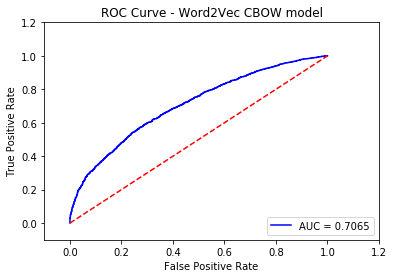

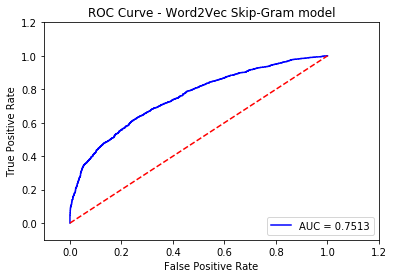

In [63]:
# ROC curve and AUC score for Skip-Gram and CBOW models

create_ROC_AUC(msr_wdcbow_scores, 'Word2Vec CBOW model')
create_ROC_AUC(msr_wdsg_scores, 'Word2Vec Skip-Gram model')

## GloVe

In [64]:
# Load pretrained corpus of GloVe vectors

#glove2word2vec(glove_input_file="glove.6B.300d.txt", word2vec_output_file="gensim_glove_vectors.txt")

modelgl_pret = KeyedVectors.load_word2vec_format('gensim_glove_vectors.txt', binary=False)  

In [65]:
# Implementation

sick_glpret_scores = run_gensim_model(sick_words_list, modelgl_pret)
msr_glpret_scores = run_gensim_model(msr_words_list, modelgl_pret)

In [ ]:
sick_glpret_scores

In [ ]:
msr_glpret_scores

In [ ]:
#modelgl_spacy = spacy.load("en_vectors_web_lg")

In [146]:
#modelgl_spacy = spacy.load("en", vectors="glove.6B.300d.txt")

In [147]:
# Implementation

#sick_glspacy_scores = run_spacy_model(sick_filtered, modelgl_spacy)
#msr_glspacy_scores = run_spacy_model(msr_filtered, modelgl_spacy)

In [ ]:
#sick_glspacy_scores

In [ ]:
#msr_glspacy_scores

In [66]:
# Load trained GloVe model using demo.sh

#glove2word2vec(glove_input_file="/project/GloVe/modelgl_train.txt", word2vec_output_file="modelgl_vectors.txt")

# Load pretrained corpus of GloVe vectors
modelgl_train = KeyedVectors.load_word2vec_format('modelgl_vectors.txt', binary=False)  

In [152]:
modelgl_train.most_similar('frog')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('frogs', 0.5380728840827942),
 ('spider', 0.4365730881690979),
 ('snake', 0.4340173602104187),
 ('monkey', 0.42525428533554077),
 ('ape', 0.4224390983581543),
 ('turtle', 0.40069910883903503),
 ('dinosaur', 0.3949301540851593),
 ('snakes', 0.39383214712142944),
 ('rabbit', 0.39103496074676514),
 ('leopard', 0.38695842027664185)]

In [54]:
#modelgl_train.word_vectors[modelgl_train.dictionary['frog']]

In [67]:
# Implementation

sick_gltrain_scores = run_gensim_model(sick_words_list, modelgl_train)
msr_gltrain_scores = run_gensim_model(msr_words_list, modelgl_train)

sick_stem_gltrain_scores = run_gensim_model(sick_stem_words_list, modelgl_train)
msr_stem_gltrain_scores = run_gensim_model(msr_stem_words_list, modelgl_train)

sick_lem_gltrain_scores = run_gensim_model(sick_lem_words_list, modelgl_train)
msr_lem_gltrain_scores = run_gensim_model(msr_lem_words_list, modelgl_train)

sick_stw_gltrain_scores = run_gensim_model(sick_stw_words_list, modelgl_train)
msr_stw_gltrain_scores = run_gensim_model(msr_stw_words_list, modelgl_train)

sick_stemstw_gltrain_scores = run_gensim_model(sick_stemstw_words_list, modelgl_train)
msr_stemstw_gltrain_scores = run_gensim_model(msr_stemstw_words_list, modelgl_train)

sick_lemstw_gltrain_scores = run_gensim_model(sick_lemstw_words_list, modelgl_train)
msr_lemstw_gltrain_scores = run_gensim_model(msr_lemstw_words_list, modelgl_train)

In [ ]:
sick_gltrain_scores

In [ ]:
msr_gltrain_scores

In [68]:
df_sick_glv = pd.DataFrame({'Relatedness': sick_scores, 'GloVe_pret': sick_glpret_scores, 'GloVe_train': sick_gltrain_scores,
                            'GloVe_stem_train': sick_stem_gltrain_scores, 'GloVe_lem_train': sick_lem_gltrain_scores, 
                            'GloVe_stw_train': sick_stw_gltrain_scores, 'GloVe_stemstw_train': sick_stemstw_gltrain_scores, 
                            'GloVe_lemstw_train': sick_lemstw_gltrain_scores})
df_sick_glv

,Relatedness,GloVe_pret,GloVe_train,GloVe_stem_train,GloVe_lem_train,GloVe_stw_train,GloVe_stemstw_train,GloVe_lemstw_train
0,4.500,0.988511,0.992600,0.993078,0.992945,0.970583,0.969096,0.969096
1,3.200,0.973246,0.986202,0.983597,0.985147,0.949778,0.937527,0.938729
2,4.700,0.921689,0.927799,0.933302,0.936382,0.906823,0.918139,0.930987
3,3.600,0.900771,0.920160,0.929123,0.929231,0.934975,0.979302,0.945433
4,3.400,0.920656,0.943302,0.945448,0.949895,0.857522,0.853414,0.845976
5,3.300,0.873997,0.903833,0.906375,0.893216,0.814277,0.826266,0.787942
6,3.700,0.881097,0.921183,0.927272,0.930215,0.871810,0.870233,0.868506
7,3.000,0.897358,0.947360,0.946683,0.946043,0.866037,0.838869,0.840032
8,3.700,0.891473,0.932314,0.933346,0.935360,0.866916,0.842992,0.842586
9,4.900,0.991451,0.995768,0.994664,0.995646,0.982314,0.969913,0.980663


In [69]:
# Implementation

get_first_row(df_sick_glv)

,Pearson,Spearman
Correlation,,
GloVe_pret,0.629129,0.559256
GloVe_train,0.524698,0.505070
GloVe_stem_train,0.503239,0.495756
GloVe_lem_train,0.547467,0.523910
GloVe_stw_train,0.628135,0.535484
GloVe_stemstw_train,0.568904,0.517478
GloVe_lemstw_train,0.639904,0.553012


In [70]:
print('\nORIG')
print(all_accuracy_thresholds(msr_gltrain_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_gltrain_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_gltrain_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_gltrain_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_gltrain_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_gltrain_scores))
print('\nGloVe')


ORIG
Accuracy    0.701431
F1 score    0.792525
Name: 0.95, dtype: float64

STEM
Accuracy    0.690915
F1 score    0.791342
Name: 0.94, dtype: float64

LEM
Accuracy    0.700914
F1 score    0.794747
Name: 0.95, dtype: float64

STW
Accuracy    0.694191
F1 score    0.785490
Name: 0.89, dtype: float64

STEMSW
Accuracy    0.677642
F1 score    0.802116
Name: 0.69, dtype: float64

LEMSW
Accuracy    0.697638
F1 score    0.789132
Name: 0.89, dtype: float64

GloVe


In [71]:
# Convert scores to binary

msr_glpret_binscores = convert_scores_to_binary(msr_glpret_scores, 0.92)
#msr_glspacy_binscores = convert_scores_to_binary(msr_glspacy_scores, 0.7)
msr_gltrain_binscores = convert_scores_to_binary(msr_gltrain_scores, 0.95)
msr_stem_gltrain_binscores = convert_scores_to_binary(msr_stem_gltrain_scores, 0.94)
msr_lem_gltrain_binscores = convert_scores_to_binary(msr_lem_gltrain_scores, 0.95)
msr_stw_gltrain_binscores = convert_scores_to_binary(msr_stw_gltrain_scores, 0.89)
msr_stemstw_gltrain_binscores = convert_scores_to_binary(msr_stemstw_gltrain_scores, 0.69)
msr_lemstw_gltrain_binscores = convert_scores_to_binary(msr_lemstw_gltrain_scores, 0.89)

In [72]:
df_msr_glv = pd.DataFrame({'Similarity': msr_scores, 'GloVe_pret_0.92': msr_glpret_binscores, 'GloVe_train_0.95': msr_gltrain_binscores,
                           'GloVe_stem_train_0.94': msr_stem_gltrain_binscores, 'GloVe_lem_train_0.95': msr_lem_gltrain_binscores, 
                           'GloVe_stw_train_0.89': msr_stw_gltrain_binscores, 'GloVe_stemstw_train_0.69': msr_stemstw_gltrain_binscores, 
                           'GloVe_lemstw_train_0.89': msr_lemstw_gltrain_binscores})
df_msr_glv

,Similarity,GloVe_pret_0.92,GloVe_train_0.95,GloVe_stem_train_0.94,GloVe_lem_train_0.95,GloVe_stw_train_0.89,GloVe_stemstw_train_0.69,GloVe_lemstw_train_0.89
0,1,1,1,1,1,1,1,1
1,0,1,1,1,1,0,1,1
2,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,1,0
7,1,0,1,1,1,0,1,1
8,0,0,0,0,0,0,1,0
9,1,1,0,0,1,1,1,1


In [73]:
# Implementation

show_class_scores(df_msr_glv)

,Accuracy,F1 score
Classification,,
GloVe_pret_0.92,0.716601,0.807359
GloVe_train_0.95,0.701431,0.792525
GloVe_stem_train_0.94,0.690915,0.791342
GloVe_lem_train_0.95,0.700914,0.794747
GloVe_stw_train_0.89,0.694191,0.785490
GloVe_stemstw_train_0.69,0.677642,0.802116
GloVe_lemstw_train_0.89,0.697638,0.789132


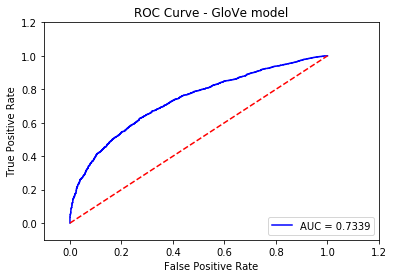

In [74]:
# ROC curve and AUC score for GloVe model

create_ROC_AUC(msr_gltrain_scores, 'GloVe model')

## fastText

In [75]:
# Load trained CBOW and Skip-Gram models

modelft_cbow = FastText.load_fasttext_format('/project/fastText/modelft_cbow.bin')
modelft_sg = FastText.load_fasttext_format('/project/fastText/modelft_sg.bin')

In [225]:
modelft_sg.most_similar('teacher')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('teacherÊ¼s', 0.8988542556762695),
 ('teache', 0.8441284894943237),
 ('teacher-', 0.8323448300361633),
 ('teacherly', 0.8160091638565063),
 ('teacher-pupil', 0.8082339763641357),
 ('pupil-teacher', 0.8017261028289795),
 ('school-teacher', 0.7993281483650208),
 ('co-teacher', 0.7805333137512207),
 ('teacher.', 0.7613403797149658),
 ('schoolteacher', 0.7582474946975708)]

In [226]:
modelft_cbow.similarity('teacher', 'lecturer')

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.67380166

In [76]:
# Implementation

sick_ftsg_scores = run_gensim_model(sick_words_list, modelft_sg)
sick_ftcbow_scores = run_gensim_model(sick_words_list, modelft_cbow)
msr_ftsg_scores = run_gensim_model(msr_words_list, modelft_sg)
msr_ftcbow_scores = run_gensim_model(msr_words_list, modelft_cbow)

sick_stem_ftsg_scores = run_gensim_model(sick_stem_words_list, modelft_sg)
sick_stem_ftcbow_scores = run_gensim_model(sick_stem_words_list, modelft_cbow)
msr_stem_ftsg_scores = run_gensim_model(msr_stem_words_list, modelft_sg)
msr_stem_ftcbow_scores = run_gensim_model(msr_stem_words_list, modelft_cbow)

sick_lem_ftsg_scores = run_gensim_model(sick_lem_words_list, modelft_sg)
sick_lem_ftcbow_scores = run_gensim_model(sick_lem_words_list, modelft_cbow)
msr_lem_ftsg_scores = run_gensim_model(msr_lem_words_list, modelft_sg)
msr_lem_ftcbow_scores = run_gensim_model(msr_lem_words_list, modelft_cbow)

sick_stw_ftsg_scores = run_gensim_model(sick_stw_words_list, modelft_sg)
sick_stw_ftcbow_scores = run_gensim_model(sick_stw_words_list, modelft_cbow)
msr_stw_ftsg_scores = run_gensim_model(msr_stw_words_list, modelft_sg)
msr_stw_ftcbow_scores = run_gensim_model(msr_stw_words_list, modelft_cbow)

sick_stemstw_ftsg_scores = run_gensim_model(sick_stemstw_words_list, modelft_sg)
sick_stemstw_ftcbow_scores = run_gensim_model(sick_stemstw_words_list, modelft_cbow)
msr_stemstw_ftsg_scores = run_gensim_model(msr_stemstw_words_list, modelft_sg)
msr_stemstw_ftcbow_scores = run_gensim_model(msr_stemstw_words_list, modelft_cbow)

sick_lemstw_ftsg_scores = run_gensim_model(sick_lemstw_words_list, modelft_sg)
sick_lemstw_ftcbow_scores = run_gensim_model(sick_lemstw_words_list, modelft_cbow)
msr_lemstw_ftsg_scores = run_gensim_model(msr_lemstw_words_list, modelft_sg)
msr_lemstw_ftcbow_scores = run_gensim_model(msr_lemstw_words_list, modelft_cbow)

In [ ]:
sick_ftcbow_scores

In [ ]:
msr_ftsg_scores

In [77]:
df_sick_ft = pd.DataFrame({'Relatedness': sick_scores, 'fastText_cbow': sick_ftcbow_scores, 'fastText_sg': sick_ftsg_scores,
                           'fastText_stem_cbow': sick_stem_ftcbow_scores, 'fastText_stem_sg': sick_stem_ftsg_scores,
                           'fastText_lem_cbow': sick_lem_ftcbow_scores, 'fastText_lem_sg': sick_lem_ftsg_scores,
                           'fastText_stw_cbow': sick_stw_ftcbow_scores, 'fastText_stw_sg': sick_stw_ftsg_scores,
                           'fastText_stemstw_cbow': sick_stemstw_ftcbow_scores, 'fastText_stemstw_sg': sick_stemstw_ftsg_scores,
                           'fastText_lemstw_cbow': sick_lemstw_ftcbow_scores, 'fastText_lemstw_sg': sick_lemstw_ftsg_scores})
df_sick_ft

,Relatedness,fastText_cbow,fastText_sg,fastText_stem_cbow,fastText_stem_sg,fastText_lem_cbow,fastText_lem_sg,fastText_stw_cbow,fastText_stw_sg,fastText_stemstw_cbow,fastText_stemstw_sg,fastText_lemstw_cbow,fastText_lemstw_sg
0,4.500,0.974920,0.984590,0.973600,0.984033,0.976038,0.984085,0.951237,0.967181,0.938041,0.962844,0.938041,0.962844
1,3.200,0.935109,0.964444,0.925188,0.955507,0.937497,0.959396,0.913256,0.920796,0.894105,0.898984,0.893755,0.903546
2,4.700,0.788712,0.929405,0.794332,0.939458,0.793499,0.939940,0.931676,0.918734,0.939674,0.927535,0.939870,0.941339
3,3.600,0.785692,0.891644,0.788440,0.899544,0.858997,0.906268,0.932896,0.941210,0.974733,0.958486,0.972004,0.954547
4,3.400,0.898891,0.908644,0.895165,0.910426,0.910450,0.913969,0.863299,0.832658,0.855556,0.826787,0.861425,0.828923
5,3.300,0.681911,0.854506,0.666623,0.855634,0.716551,0.845166,0.857121,0.818721,0.845500,0.812277,0.842492,0.794268
6,3.700,0.743055,0.881730,0.751156,0.887515,0.797048,0.892151,0.922746,0.850706,0.915926,0.829240,0.915466,0.833720
7,3.000,0.868784,0.884242,0.850334,0.880895,0.875642,0.881772,0.905549,0.823465,0.844640,0.783852,0.852434,0.787185
8,3.700,0.805467,0.889790,0.800093,0.892468,0.836362,0.895409,0.910028,0.846389,0.876528,0.817140,0.874436,0.821788
9,4.900,0.996331,0.988892,0.996230,0.990374,0.996595,0.989021,0.989940,0.980822,0.989513,0.984416,0.989500,0.981121


In [78]:
# Implementation

get_first_row(df_sick_ft)

,Pearson,Spearman
Correlation,,
fastText_cbow,0.370005,0.407410
fastText_sg,0.695887,0.602380
fastText_stem_cbow,0.390594,0.411829
fastText_stem_sg,0.691643,0.602473
fastText_lem_cbow,0.402319,0.433452
fastText_lem_sg,0.703738,0.616414
fastText_stw_cbow,0.599998,0.510880
fastText_stw_sg,0.708343,0.580523
fastText_stemstw_cbow,0.619232,0.535060


In [79]:
print('\nORIG')
print(all_accuracy_thresholds(msr_ftcbow_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_ftcbow_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_ftcbow_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_ftcbow_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_ftcbow_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_ftcbow_scores))
print('\nCBOW/SG')
print('\nORIG')
print(all_accuracy_thresholds(msr_ftsg_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_ftsg_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_ftsg_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_ftsg_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_ftsg_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_ftsg_scores))
print('\nCBOW/SG')


ORIG
Accuracy    0.705051
F1 score    0.802402
Name: 0.9, dtype: float64

STEM
Accuracy    0.702465
F1 score    0.801198
Name: 0.89, dtype: float64

LEM
Accuracy    0.702637
F1 score    0.810043
Name: 0.87, dtype: float64

STW
Accuracy    0.701086
F1 score    0.796908
Name: 0.9, dtype: float64

STEMSW
Accuracy    0.699879
F1 score    0.796778
Name: 0.88, dtype: float64

LEMSW
Accuracy    0.703672
F1 score    0.801844
Name: 0.88, dtype: float64

CBOW/SG

ORIG
Accuracy    0.722117
F1 score    0.812558
Name: 0.92, dtype: float64

STEM
Accuracy    0.719014
F1 score    0.813288
Name: 0.91, dtype: float64

LEM
Accuracy    0.721944
F1 score    0.813332
Name: 0.92, dtype: float64

STW
Accuracy    0.704534
F1 score    0.802898
Name: 0.88, dtype: float64

STEMSW
Accuracy    0.701776
F1 score    0.793062
Name: 0.89, dtype: float64

LEMSW
Accuracy    0.707637
F1 score    0.797951
Name: 0.89, dtype: float64

CBOW/SG


In [80]:
# Convert scores to binary

msr_ftcbow_binscores = convert_scores_to_binary(msr_ftcbow_scores, 0.90)
msr_ftsg_binscores = convert_scores_to_binary(msr_ftsg_scores, 0.92)

msr_stem_ftcbow_binscores = convert_scores_to_binary(msr_stem_ftcbow_scores, 0.89)
msr_stem_ftsg_binscores = convert_scores_to_binary(msr_stem_ftsg_scores, 0.91)

msr_lem_ftcbow_binscores = convert_scores_to_binary(msr_lem_ftcbow_scores, 0.87)
msr_lem_ftsg_binscores = convert_scores_to_binary(msr_lem_ftsg_scores, 0.92)

msr_stw_ftcbow_binscores = convert_scores_to_binary(msr_stw_ftcbow_scores, 0.90)
msr_stw_ftsg_binscores = convert_scores_to_binary(msr_stw_ftsg_scores, 0.88)

msr_stemstw_ftcbow_binscores = convert_scores_to_binary(msr_stemstw_ftcbow_scores, 0.88)
msr_stemstw_ftsg_binscores = convert_scores_to_binary(msr_stemstw_ftsg_scores, 0.89)

msr_lemstw_ftcbow_binscores = convert_scores_to_binary(msr_lemstw_ftcbow_scores, 0.88)
msr_lemstw_ftsg_binscores = convert_scores_to_binary(msr_lemstw_ftsg_scores, 0.89)

In [81]:
df_msr_ft = pd.DataFrame({'Similarity': msr_scores, 'fastText_cbow_0.90': msr_ftcbow_binscores, 'fastText_sg_0.92': msr_ftsg_binscores,
                          'fastText_stem_cbow_0.89': msr_stem_ftcbow_binscores, 'fastText_stem_sg_0.91': msr_stem_ftsg_binscores,
                          'fastText_lem_cbow_0.87': msr_lem_ftcbow_binscores, 'fastText_lem_sg_0.92': msr_lem_ftsg_binscores,
                          'fastText_stw_cbow_0.90': msr_stw_ftcbow_binscores, 'fastText_stw_sg_0.88': msr_stw_ftsg_binscores,
                          'fastText_stemstw_cbow_0.88': msr_stemstw_ftcbow_binscores, 'fastText_stemstw_sg_0.89': msr_stemstw_ftsg_binscores,
                          'fastText_lemstw_cbow_0.88': msr_lemstw_ftcbow_binscores, 'fastText_lemstw_sg_0.89': msr_lemstw_ftsg_binscores})
df_msr_ft

,Similarity,fastText_cbow_0.90,fastText_sg_0.92,fastText_stem_cbow_0.89,fastText_stem_sg_0.91,fastText_lem_cbow_0.87,fastText_lem_sg_0.92,fastText_stw_cbow_0.90,fastText_stw_sg_0.88,fastText_stemstw_cbow_0.88,fastText_stemstw_sg_0.89,fastText_lemstw_cbow_0.88,fastText_lemstw_sg_0.89
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,0,1,0,1,1,1
2,1,1,1,1,1,1,1,1,1,0,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,1,1,0,1,0,1,0,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1


In [82]:
# Implementation

show_class_scores(df_msr_ft)

,Accuracy,F1 score
Classification,,
fastText_cbow_0.90,0.705051,0.802402
fastText_sg_0.92,0.722117,0.812558
fastText_stem_cbow_0.89,0.702465,0.801198
fastText_stem_sg_0.91,0.719014,0.813288
fastText_lem_cbow_0.87,0.702637,0.810043
fastText_lem_sg_0.92,0.721944,0.813332
fastText_stw_cbow_0.90,0.701086,0.796908
fastText_stw_sg_0.88,0.704534,0.802898
fastText_stemstw_cbow_0.88,0.699879,0.796778


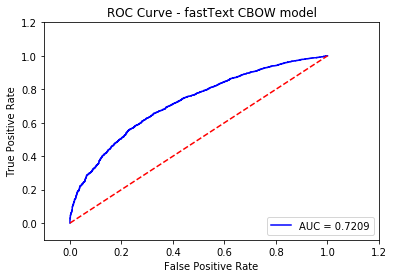

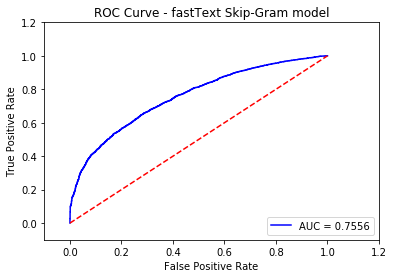

In [83]:
# ROC curve and AUC score for Skip-Gram and CBOW models

create_ROC_AUC(msr_ftcbow_scores, 'fastText CBOW model')
create_ROC_AUC(msr_ftsg_scores, 'fastText Skip-Gram model')

## Sent2Vec

In [84]:
# Load model with character bigrams

modelsn_uni = sent2vec.Sent2vecModel()
modelsn_uni.load_model('/project/sent2vec/modelsn_uni.bin')

In [85]:
# Load model with character bigrams

modelsn_bi = sent2vec.Sent2vecModel()
modelsn_bi.load_model('/project/sent2vec/modelsn_bi.bin')

In [86]:
# Implementation

sick_snuni_scores = run_sent2vec_model(sick_sentences, modelsn_uni)
msr_snuni_scores = run_sent2vec_model(msr_sentences, modelsn_uni)
sick_snbi_scores = run_sent2vec_model(sick_sentences, modelsn_bi)
msr_snbi_scores = run_sent2vec_model(msr_sentences, modelsn_bi)

sick_stem_snuni_scores = run_sent2vec_model(sick_sentences_stem, modelsn_uni)
msr_stem_snuni_scores = run_sent2vec_model(msr_sentences_stem, modelsn_uni)
sick_stem_snbi_scores = run_sent2vec_model(sick_sentences_stem, modelsn_bi)
msr_stem_snbi_scores = run_sent2vec_model(msr_sentences_stem, modelsn_bi)

sick_lem_snuni_scores = run_sent2vec_model(sick_sentences_lemma, modelsn_uni)
msr_lem_snuni_scores = run_sent2vec_model(msr_sentences_lemma, modelsn_uni)
sick_lem_snbi_scores = run_sent2vec_model(sick_sentences_lemma, modelsn_bi)
msr_lem_snbi_scores = run_sent2vec_model(msr_sentences_lemma, modelsn_bi)

sick_stw_snuni_scores = run_sent2vec_model(sick_filtered, modelsn_uni)
msr_stw_snuni_scores = run_sent2vec_model(msr_filtered, modelsn_uni)
sick_stw_snbi_scores = run_sent2vec_model(sick_filtered, modelsn_bi)
msr_stw_snbi_scores = run_sent2vec_model(msr_filtered, modelsn_bi)

sick_stemstw_snuni_scores = run_sent2vec_model(sick_stemstw, modelsn_uni)
msr_stemstw_snuni_scores = run_sent2vec_model(msr_stemstw, modelsn_uni)
sick_stemstw_snbi_scores = run_sent2vec_model(sick_stemstw, modelsn_bi)
msr_stemstw_snbi_scores = run_sent2vec_model(msr_stemstw, modelsn_bi)

sick_lemstw_snuni_scores = run_sent2vec_model(sick_lemstw, modelsn_uni)
msr_lemstw_snuni_scores = run_sent2vec_model(msr_lemstw, modelsn_uni)
sick_lemstw_snbi_scores = run_sent2vec_model(sick_lemstw, modelsn_bi)
msr_lemstw_snbi_scores = run_sent2vec_model(msr_lemstw, modelsn_bi)

In [ ]:
sick_snuni_scores

In [ ]:
msr_snbi_scores

In [87]:
df_sick_s2v = pd.DataFrame({'Relatedness': sick_scores, 'sent2vec_uni': sick_snuni_scores, 'sent2vec_bi': sick_snbi_scores,
                            'sent2vec_stem_uni': sick_stem_snuni_scores, 'sent2vec_stem_bi': sick_stem_snbi_scores,
                            'sent2vec_lem_uni': sick_lem_snuni_scores, 'sent2vec_lem_bi': sick_lem_snbi_scores,
                            'sent2vec_stw_uni': sick_stw_snuni_scores, 'sent2vec_stw_bi': sick_stw_snbi_scores,
                            'sent2vec_stemstw_uni': sick_stemstw_snuni_scores, 'sent2vec_stemstw_bi': sick_stemstw_snbi_scores,
                            'sent2vec_lemstw_uni': sick_lemstw_snuni_scores, 'sent2vec_lemstw_bi': sick_lemstw_snbi_scores})
df_sick_s2v

,Relatedness,sent2vec_uni,sent2vec_bi,sent2vec_stem_uni,sent2vec_stem_bi,sent2vec_lem_uni,sent2vec_lem_bi,sent2vec_stw_uni,sent2vec_stw_bi,sent2vec_stemstw_uni,sent2vec_stemstw_bi,sent2vec_lemstw_uni,sent2vec_lemstw_bi
0,4.500,0.916930,0.902060,0.915153,0.924955,0.936318,0.935062,0.936909,0.868952,0.939582,0.931216,0.939582,0.931216
1,3.200,0.799984,0.813195,0.781763,0.789918,0.835029,0.827219,0.863272,0.805650,0.849630,0.824038,0.853982,0.828374
2,4.700,0.761937,0.784431,0.814782,0.787116,0.845997,0.817700,0.822276,0.824655,0.910771,0.909922,0.923340,0.915496
3,3.600,0.655813,0.785913,0.700540,0.770376,0.764913,0.754509,0.888199,0.902773,0.972120,0.975252,0.927023,0.927919
4,3.400,0.537681,0.677743,0.563564,0.667534,0.643582,0.725156,0.611087,0.616682,0.662107,0.699233,0.652154,0.676675
5,3.300,0.501682,0.618132,0.498251,0.612880,0.577833,0.652788,0.641254,0.601667,0.667356,0.665058,0.616929,0.614791
6,3.700,0.578204,0.754485,0.605611,0.745807,0.703852,0.806073,0.666040,0.660606,0.701760,0.708342,0.684801,0.676276
7,3.000,0.564404,0.696684,0.571507,0.661167,0.683102,0.704220,0.630953,0.643780,0.671875,0.682979,0.636579,0.611435
8,3.700,0.567924,0.737746,0.588904,0.705770,0.689431,0.766985,0.640500,0.641480,0.672435,0.663983,0.645401,0.634606
9,4.900,0.962095,0.958252,0.950658,0.940400,0.964253,0.955680,0.959375,0.953149,0.949702,0.929053,0.960235,0.948559


In [88]:
# Implementation

get_first_row(df_sick_s2v)

,Pearson,Spearman
Correlation,,
sent2vec_uni,0.703733,0.632154
sent2vec_bi,0.713177,0.623298
sent2vec_stem_uni,0.669117,0.613287
sent2vec_stem_bi,0.668159,0.599433
sent2vec_lem_uni,0.693109,0.635592
sent2vec_lem_bi,0.709206,0.635449
sent2vec_stw_uni,0.697967,0.588122
sent2vec_stw_bi,0.704688,0.583698
sent2vec_stemstw_uni,0.640458,0.560780


In [89]:
print('\nORIG')
print(all_accuracy_thresholds(msr_snuni_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_snuni_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_snuni_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_snuni_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_snuni_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_snuni_scores))
print('\nuni/bi')
print('\nORIG')
print(all_accuracy_thresholds(msr_snbi_scores))
print('\nSTEM')
print(all_accuracy_thresholds(msr_stem_snbi_scores))
print('\nLEM')
print(all_accuracy_thresholds(msr_lem_snbi_scores))
print('\nSTW')
print(all_accuracy_thresholds(msr_stw_snbi_scores))
print('\nSTEMSW')
print(all_accuracy_thresholds(msr_stemstw_snbi_scores))
print('\nLEMSW')
print(all_accuracy_thresholds(msr_lemstw_snbi_scores))
print('\nuni/bi')


ORIG
Accuracy    0.708326
F1 score    0.807989
Name: 0.65, dtype: float64

STEM
Accuracy    0.692639
F1 score    0.801293
Name: 0.57, dtype: float64

LEM
Accuracy    0.715394
F1 score    0.800772
Name: 0.71, dtype: float64

STW
Accuracy    0.705913
F1 score    0.807188
Name: 0.69, dtype: float64

STEMSW
Accuracy    0.683158
F1 score    0.798597
Name: 0.59, dtype: float64

LEMSW
Accuracy    0.707809
F1 score    0.810254
Name: 0.69, dtype: float64

uni/bi

ORIG
Accuracy    0.694708
F1 score    0.800496
Name: 0.71, dtype: float64

STEM
Accuracy    0.685744
F1 score    0.794128
Name: 0.62, dtype: float64

LEM
Accuracy    0.700569
F1 score    0.796676
Name: 0.73, dtype: float64

STW
Accuracy    0.692812
F1 score    0.800627
Name: 0.7, dtype: float64

STEMSW
Accuracy    0.677642
F1 score    0.797531
Name: 0.56, dtype: float64

LEMSW
Accuracy    0.697638
F1 score    0.797973
Name: 0.73, dtype: float64

uni/bi


In [90]:
# Convert scores to binary

msr_snuni_binscores = convert_scores_to_binary(msr_snuni_scores, 0.65)
msr_snbi_binscores = convert_scores_to_binary(msr_snbi_scores, 0.71)

msr_stem_snuni_binscores = convert_scores_to_binary(msr_stem_snuni_scores, 0.57)
msr_stem_snbi_binscores = convert_scores_to_binary(msr_stem_snbi_scores, 0.62)

msr_lem_snuni_binscores = convert_scores_to_binary(msr_lem_snuni_scores, 0.71)
msr_lem_snbi_binscores = convert_scores_to_binary(msr_lem_snbi_scores, 0.73)

msr_stw_snuni_binscores = convert_scores_to_binary(msr_stw_snuni_scores, 0.69)
msr_stw_snbi_binscores = convert_scores_to_binary(msr_stw_snbi_scores, 0.70)

msr_stemstw_snuni_binscores = convert_scores_to_binary(msr_stemstw_snuni_scores, 0.59)
msr_stemstw_snbi_binscores = convert_scores_to_binary(msr_stemstw_snbi_scores, 0.56)

msr_lemstw_snuni_binscores = convert_scores_to_binary(msr_lemstw_snuni_scores, 0.69)
msr_lemstw_snbi_binscores = convert_scores_to_binary(msr_lemstw_snbi_scores, 0.73)

In [91]:
df_msr_s2v = pd.DataFrame({'Similarity': msr_scores, 'sent2vec_uni_0.65': msr_snuni_binscores, 'sent2vec_bi_0.71': msr_snbi_binscores,
                          'sent2vec_stem_uni_0.57': msr_stem_snuni_binscores, 'sent2vec_stem_bi_0.62': msr_stem_snbi_binscores,
                          'sent2vec_lem_uni_0.71': msr_lem_snuni_binscores, 'sent2vec_lem_bi_0.73': msr_lem_snbi_binscores,
                          'sent2vec_stw_uni_0.69': msr_stw_snuni_binscores, 'sent2vec_stw_bi_0.70': msr_stw_snbi_binscores,
                          'sent2vec_stemstw_uni_0.59': msr_stemstw_snuni_binscores, 'sent2vec_stemstw_bi_0.56': msr_stemstw_snbi_binscores,
                          'sent2vec_lemstw_uni_0.69': msr_lemstw_snuni_binscores, 'sent2vec_lemstw_bi_0.73': msr_lemstw_snbi_binscores})
df_msr_s2v

,Similarity,sent2vec_uni_0.65,sent2vec_bi_0.71,sent2vec_stem_uni_0.57,sent2vec_stem_bi_0.62,sent2vec_lem_uni_0.71,sent2vec_lem_bi_0.73,sent2vec_stw_uni_0.69,sent2vec_stw_bi_0.70,sent2vec_stemstw_uni_0.59,sent2vec_stemstw_bi_0.56,sent2vec_lemstw_uni_0.69,sent2vec_lemstw_bi_0.73
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,0,0,0,0,0,0,0,0,0,1,0,0
7,1,1,1,1,1,1,0,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1


In [92]:
# Implementation

show_class_scores(df_msr_s2v)

,Accuracy,F1 score
Classification,,
sent2vec_uni_0.65,0.708326,0.807989
sent2vec_bi_0.71,0.694708,0.800496
sent2vec_stem_uni_0.57,0.692639,0.801293
sent2vec_stem_bi_0.62,0.685744,0.794128
sent2vec_lem_uni_0.71,0.715394,0.800772
sent2vec_lem_bi_0.73,0.700569,0.796676
sent2vec_stw_uni_0.69,0.705913,0.807188
sent2vec_stw_bi_0.70,0.692812,0.800627
sent2vec_stemstw_uni_0.59,0.683158,0.798597


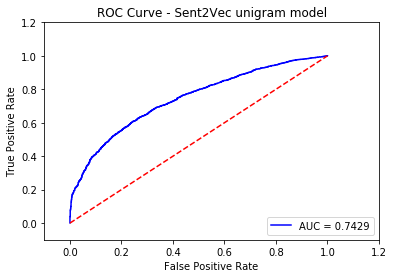

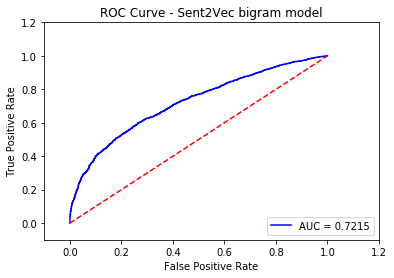

In [93]:
# ROC curve and AUC score for sent2vec models

create_ROC_AUC(msr_snuni_scores, 'Sent2Vec unigram model')
create_ROC_AUC(msr_snbi_scores, 'Sent2Vec bigram model')

## Doc2Vec

In [94]:
def create_docs_list(sentences):
    
    '''Creates a list of sentences corresponding to a document'''
    
    docs_list = []
    for pair in sentences:
        docs_list.append(pair[0])
        docs_list.append(pair[1])
        
    return docs_list

In [5]:
modeldc_dm = Doc2Vec.load('dm_1__dbow_0/my_doc2vec_model')
modeldc_dbow0 = Doc2Vec.load('dm_0__dbow_0/my_doc2vec_model_v3')
modeldc_dbow1 = Doc2Vec.load('dm_0_dbow_1/my_doc2vec_model_v2')

In [16]:
modeldc_dm.wv.most_similar('kid')

[('boy', 0.5809871554374695),
 ('dude', 0.5595501065254211),
 ('teenager', 0.5559139847755432),
 ('guy', 0.540682315826416),
 ('lad', 0.5132332444190979),
 ('girl', 0.5101467967033386),
 ('toddler', 0.4931091368198395),
 ('jokester', 0.48431500792503357),
 ('bloke', 0.4837813973426819),
 ('kids', 0.48043715953826904)]

In [ ]:
modeldc_dm.infer_vector(sick_docs_list[0])

In [95]:
# Implementation

sick_docs_list = create_docs_list(sick_sentences)
msr_docs_list = create_docs_list(msr_sentences)

sick_stem_docs_list = create_docs_list(sick_sentences_stem)
msr_stem_docs_list = create_docs_list(msr_sentences_stem)

sick_lem_docs_list = create_docs_list(sick_sentences_lemma)
msr_lem_docs_list = create_docs_list(msr_sentences_lemma)

sick_stw_docs_list = create_docs_list(sick_filtered)
msr_stw_docs_list = create_docs_list(msr_filtered)

sick_stemstw_docs_list = create_docs_list(sick_stemstw)
msr_stemstw_docs_list = create_docs_list(msr_stemstw)

sick_lemstw_docs_list = create_docs_list(sick_lemstw)
msr_lemstw_docs_lists = create_docs_list(msr_lemstw)

In [ ]:
sick_tagged_docs

In [ ]:
msr_tagged_docs

In [ ]:
# Implementation

sick_dcdm_scores = run_doc2vec_model(sick_docs_list, modeldc_dm)
sick_dcdbow0_scores = run_doc2vec_model(sick_docs_list, modeldc_dbow0)
sick_dcdbow1_scores = run_doc2vec_model(sick_docs_list, modeldc_dbow1)
msr_dcdm_scores = run_doc2vec_model(msr_docs_list, modeldc_dm)
msr_dcdbow0_scores = run_doc2vec_model(msr_docs_list, modeldc_dbow0)
msr_dcdbow1_scores = run_doc2vec_model(msr_docs_list, modeldc_dbow1)

sick_stem_dcdm_scores = run_doc2vec_model(sick_stem_docs_list, modeldc_dm)
sick_stem_dcdbow0_scores = run_doc2vec_model(sick_stem_docs_list, modeldc_dbow0)
sick_stem_dcdbow1_scores = run_doc2vec_model(sick_stem_docs_list, modeldc_dbow1)
msr_stem_dcdm_scores = run_doc2vec_model(msr_stem_docs_list, modeldc_dm)
msr_stem_dcdbow0_scores = run_doc2vec_model(msr_stem_docs_list, modeldc_dbow0)
msr_stem_dcdbow1_scores = run_doc2vec_model(msr_stem_docs_list, modeldc_dbow1)

sick_lem_dcdm_scores = run_doc2vec_model(sick_lem_docs_list, modeldc_dm)
sick_lem_dcdbow0_scores = run_doc2vec_model(sick_lem_docs_list, modeldc_dbow0)
sick_lem_dcdbow1_scores = run_doc2vec_model(sick_lem_docs_list, modeldc_dbow1)
msr_lem_dcdm_scores = run_doc2vec_model(msr_lem_docs_list, modeldc_dm)
msr_lem_dcdbow0_scores = run_doc2vec_model(msr_lem_docs_list, modeldc_dbow0)
msr_lem_dcdbow1_scores = run_doc2vec_model(msr_lem_docs_list, modeldc_dbow1)

sick_stw_dcdm_scores = run_doc2vec_model(sick_stw_docs_list, modeldc_dm)
sick_stw_dcdbow0_scores = run_doc2vec_model(sick_stw_docs_list, modeldc_dbow0)
sick_stw_dcdbow1_scores = run_doc2vec_model(sick_stw_docs_list, modeldc_dbow1)
msr_stw_dcdm_scores = run_doc2vec_model(msr_stw_docs_list, modeldc_dm)
msr_stw_dcdbow0_scores = run_doc2vec_model(msr_stw_docs_list, modeldc_dbow0)
msr_stw_dcdbow1_scores = run_doc2vec_model(msr_stw_docs_list, modeldc_dbow1)

sick_stemstw_dcdm_scores = run_doc2vec_model(sick_stemstw_docs_list, modeldc_dm)
sick_stemstw_dcdbow0_scores = run_doc2vec_model(sick_stemstw_docs_list, modeldc_dbow0)
sick_stemstw_dcdbow1_scores = run_doc2vec_model(sick_stemstw_docs_list, modeldc_dbow1)
msr_stemstw_dcdm_scores = run_doc2vec_model(msr_stemstw_docs_list, modeldc_dm)
msr_stemstw_dcdbow0_scores = run_doc2vec_model(msr_stemstw_docs_list, modeldc_dbow0)
msr_stemstw_dcdbow1_scores = run_doc2vec_model(msr_stemstw_docs_list, modeldc_dbow1)

sick_lemstw_dcdm_scores = run_doc2vec_model(sick_lemstw_docs_list, modeldc_dm)
sick_lemstw_dcdbow0_scores = run_doc2vec_model(sick_lemstw_docs_list, modeldc_dbow0)
sick_lemstw_dcdbow1_scores = run_doc2vec_model(sick_lemstw_docs_list, modeldc_dbow1)
msr_lemstw_dcdm_scores = run_doc2vec_model(msr_lemstw_docs_list, modeldc_dm)
msr_lemstw_dcdbow0_scores = run_doc2vec_model(msr_lemstw_docs_list, modeldc_dbow0)
msr_lemstw_dcdbow1_scores = run_doc2vec_model(msr_lemstw_docs_list, modeldc_dbow1)

In [1086]:
df_sick_d2v = pd.DataFrame({'Relatedness': sick_scores, 'Doc2Vec_dm': sick_dcdm_scores, 'Doc2Vec_dbow0': sick_dcdbow0_scores,
                            'Doc2Vec_dbow1': sick_dcdbow1_scores, 'Doc2Vec_stem_dm': sick_stem_dcdm_scores, 
                            'Doc2Vec_stem_dbow0': sick_stem_dcdbow0_scores, 'Doc2Vec_stem_dbow1': sick_stem_dcdbow1_scores, 
                            'Doc2Vec_lem_dm': sick_lem_dcdm_scores, 'Doc2Vec_lem_dbow0': sick_lem_dcdbow0_scores,
                            'Doc2Vec_lem_dbow1': sick_lem_dcdbow1_scores, 'Doc2Vec_stw_dm': sick_stw_dcdm_scores, 
                            'Doc2Vec_stw_dbow0': sick_stw_dcdbow0_scores, 'Doc2Vec_stw_dbow1': sick_stw_dcdbow1_scores, 
                            'Doc2Vec_stemstw_dm': sick_stemstw_dcdm_scores, 'Doc2Vec_stemstw_dbow0': sick_stemstw_dcdbow0_scores,
                            'Doc2Vec_stemstw_dbow1': sick_stemstw_dcdbow1_scores, 'Doc2Vec_lemstw_dm': sick_lemstw_dcdm_scores, 
                            'Doc2Vec_lemstw_dbow0': sick_lemstw_dcdbow0_scores, 'Doc2Vec_lemstw_dbow1': sick_lemstw_dcdbow1_scores})
df_sick_d2v

,Relatedness,Doc2Vec_dm,Doc2Vec_dbow0,Doc2Vec_dbow1,Doc2Vec_stem_dm,Doc2Vec_stem_dbow0,Doc2Vec_stem_dbow1,Doc2Vec_lem_dm,Doc2Vec_lem_dbow0,Doc2Vec_lem_dbow1,Doc2Vec_stw_dm,Doc2Vec_stw_dbow0,Doc2Vec_stw_dbow1,Doc2Vec_stemstw_dm,Doc2Vec_stemstw_dbow0,Doc2Vec_stemstw_dbow1,Doc2Vec_lemstw_dm,Doc2Vec_lemstw_dbow0,Doc2Vec_lemstw_dbow1
0,4.500,0.815203,0.379735,0.934572,0.839470,0.683313,0.912714,0.924747,0.619406,0.932726,0.846536,0.581387,0.943649,0.820791,0.600669,0.925265,0.889903,0.527307,0.899262
1,3.200,0.821268,0.603819,0.924767,0.832171,0.575958,0.926272,0.830106,0.681647,0.937949,0.891784,0.669365,0.924932,0.861009,0.593782,0.920889,0.783325,0.668209,0.917148
2,4.700,0.808711,0.597634,0.916063,0.870998,0.620666,0.923091,0.788822,0.385636,0.911825,0.853780,0.627368,0.903232,0.864426,0.672999,0.898139,0.858212,0.561890,0.886051
3,3.600,0.800902,0.628077,0.919019,0.750640,0.621073,0.925978,0.869964,0.651053,0.910334,0.816745,0.676940,0.905697,0.873017,0.596495,0.908468,0.854790,0.654067,0.922706
4,3.400,0.661437,0.456694,0.919809,0.790314,0.368760,0.888662,0.786730,0.355199,0.900783,0.748910,0.642880,0.909980,0.811908,0.483841,0.894105,0.793403,0.618281,0.891104
5,3.300,0.824085,0.670122,0.893957,0.813011,0.622279,0.894866,0.762059,0.636933,0.903938,0.835004,0.575358,0.886126,0.814455,0.695264,0.913456,0.786137,0.568503,0.876867
6,3.700,0.780531,0.551310,0.904912,0.809220,0.354287,0.912566,0.861456,0.587110,0.904104,0.753659,0.632485,0.903042,0.867414,0.532609,0.894414,0.863073,0.553450,0.892431
7,3.000,0.778133,0.377512,0.922399,0.735851,0.590186,0.918742,0.771706,0.564815,0.930466,0.862474,0.616272,0.905816,0.844812,0.511878,0.902850,0.791430,0.667351,0.916825
8,3.700,0.835145,0.403378,0.922743,0.830409,0.556733,0.911722,0.801278,0.626009,0.912860,0.863536,0.638430,0.898466,0.875809,0.643541,0.919020,0.865187,0.600411,0.921728
9,4.900,0.838096,0.593119,0.922472,0.875946,0.375038,0.930630,0.717955,0.626775,0.938257,0.865623,0.578563,0.922282,0.795254,0.655615,0.929670,0.817323,0.653956,0.919432


In [1087]:
get_first_row(df_sick_d2v)

,Pearson,Spearman
Correlation,,
Doc2Vec_dm,0.173312,0.178400
Doc2Vec_dbow0,0.069810,0.069164
Doc2Vec_dbow1,0.305787,0.248095
Doc2Vec_stem_dm,0.200738,0.191301
Doc2Vec_stem_dbow0,0.052341,0.052976
Doc2Vec_stem_dbow1,0.301259,0.244717
Doc2Vec_lem_dm,0.175690,0.178245
Doc2Vec_lem_dbow0,0.073477,0.071811
Doc2Vec_lem_dbow1,0.310745,0.257809


In [1088]:
# Convert scores to binary

msr_dcdm_binscores = convert_scores_to_binary(msr_dcdm_scores, 0.6)
msr_dcdbow0_binscores = convert_scores_to_binary(msr_dcdbow0_scores, 0.34)
msr_dcdbow1_binscores = convert_scores_to_binary(msr_dcdbow1_scores, 0.91)

msr_stem_dcdm_binscores = convert_scores_to_binary(msr_stem_dcdm_scores, 0.65)
msr_stem_dcdbow0_binscores = convert_scores_to_binary(msr_stem_dcdbow0_scores, 0.0)
msr_stem_dcdbow1_binscores = convert_scores_to_binary(msr_stem_dcdbow1_scores, 0.9)

msr_lem_dcdm_binscores = convert_scores_to_binary(msr_lem_dcdm_scores, 0.64)
msr_lem_dcdbow0_binscores = convert_scores_to_binary(msr_lem_dcdbow0_scores, 0.22)
msr_lem_dcdbow1_binscores = convert_scores_to_binary(msr_lem_dcdbow1_scores, 0.89)

msr_stw_dcdm_binscores = convert_scores_to_binary(msr_stw_dcdm_scores, 0.45)
msr_stw_dcdbow0_binscores = convert_scores_to_binary(msr_stw_dcdbow0_scores, 0.31)
msr_stw_dcdbow1_binscores = convert_scores_to_binary(msr_stw_dcdbow1_scores, 0.87)

msr_stemstw_dcdm_binscores = convert_scores_to_binary(msr_stemstw_dcdm_scores, 0.47)
msr_stemstw_dcdbow0_binscores = convert_scores_to_binary(msr_stemstw_dcdbow0_scores, 0.25)
msr_stemstw_dcdbow1_binscores = convert_scores_to_binary(msr_stemstw_dcdbow1_scores, 0.87)

msr_lemstw_dcdm_binscores = convert_scores_to_binary(msr_lemstw_dcdm_scores, 0.58)
msr_lemstw_dcdbow0_binscores = convert_scores_to_binary(msr_lemstw_dcdbow0_scores, 0.25)
msr_lemstw_dcdbow1_binscores = convert_scores_to_binary(msr_lemstw_dcdbow1_scores, 0.88)

In [1089]:
df_msr_d2v = pd.DataFrame({'Similarity': msr_scores, 'Doc2Vec_dm_0.60': msr_dcdm_binscores, 'Doc2Vec_dbow0_0.34': msr_dcdbow0_binscores,
                           'Doc2Vec_dbow1_0.91': msr_dcdbow1_binscores, 'Doc2Vec_stem_dm_0.65': msr_stem_dcdm_binscores, 
                           'Doc2Vec_stem_dbow0_0.00': msr_stem_dcdbow0_binscores, 'Doc2Vec_stem_dbow1_0.90': msr_stem_dcdbow1_binscores,
                           'Doc2Vec_lem_dm_0.64': msr_lem_dcdm_binscores, 'Doc2Vec_lem_dbow0_0.22': msr_lem_dcdbow0_binscores,
                           'Doc2Vec_lem_dbow1_0.89': msr_lem_dcdbow1_binscores, 'Doc2Vec_stw_dm_0.45': msr_stw_dcdm_binscores, 
                           'Doc2Vec_stw_dbow0_0.31': msr_stw_dcdbow0_binscores, 'Doc2Vec_stw_dbow1_0.87': msr_stw_dcdbow1_binscores,
                           'Doc2Vec_stemstw_dm_0.47': msr_stw_dcdm_binscores, 'Doc2Vec_stemstw_dbow0_0.25': msr_stw_dcdbow0_binscores, 
                           'Doc2Vec_stemstw_dbow1_0.87': msr_stemstw_dcdbow1_binscores, 'Doc2Vec_lemstw_dm_0.58': msr_stemstw_dcdm_binscores, 
                           'Doc2Vec_lemstw_dbow0_0.25': msr_lemstw_dcdbow0_binscores, 'Doc2Vec_lemstw_dbow1_0.88': msr_lemstw_dcdbow1_binscores})
df_msr_d2v

,Similarity,Doc2Vec_dm_0.60,Doc2Vec_dbow0_0.34,Doc2Vec_dbow1_0.91,Doc2Vec_stem_dm_0.65,Doc2Vec_stem_dbow0_0.00,Doc2Vec_stem_dbow1_0.90,Doc2Vec_lem_dm_0.64,Doc2Vec_lem_dbow0_0.22,Doc2Vec_lem_dbow1_0.89,Doc2Vec_stw_dm_0.45,Doc2Vec_stw_dbow0_0.31,Doc2Vec_stw_dbow1_0.87,Doc2Vec_stemstw_dm_0.47,Doc2Vec_stemstw_dbow0_0.25,Doc2Vec_stemstw_dbow1_0.87,Doc2Vec_lemstw_dm_0.58,Doc2Vec_lemstw_dbow0_0.25,Doc2Vec_lemstw_dbow1_0.88
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [1091]:
show_class_scores(df_msr_d2v)

,Accuracy,F1 score
Classification,,
Doc2Vec_dm_0.60,0.672987,0.804049
Doc2Vec_dbow0_0.34,0.671091,0.802484
Doc2Vec_dbow1_0.91,0.683503,0.796272
Doc2Vec_stem_dm_0.65,0.671091,0.801498
Doc2Vec_stem_dbow0_0.00,0.672298,0.804041
Doc2Vec_stem_dbow1_0.90,0.680917,0.800130
Doc2Vec_lem_dm_0.64,0.672470,0.802986
Doc2Vec_lem_dbow0_0.22,0.672125,0.803918
Doc2Vec_lem_dbow1_0.89,0.676952,0.803275


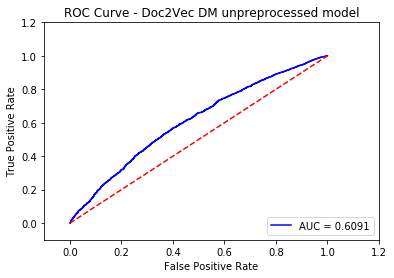

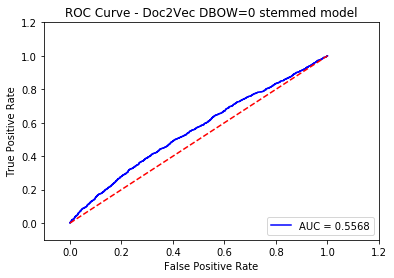

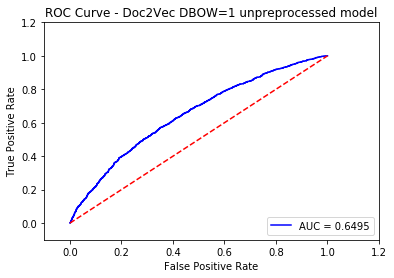

In [1092]:
# ROC curve and AUC score for doc2vec models

create_ROC_AUC(msr_dcdm_scores, 'Doc2Vec DM unpreprocessed model')
create_ROC_AUC(msr_stem_dcdbow0_scores, 'Doc2Vec DBOW=0 stemmed model')
create_ROC_AUC(msr_dcdbow1_scores, 'Doc2Vec DBOW=1 unpreprocessed model')

## Score Comparisons

In [600]:
# Compare scores from pre-trained Word2Vec and GloVe vectors

df_sick_gensim = pd.DataFrame({'Relatedness': sick_scores, 'Word2Vec_pret': sick_wdpret_scores, 'GloVe_pret': sick_glpret_scores})

get_first_row(df_sick_gensim)

,Pearson,Spearman
Correlation,,
Word2Vec_pret,0.710151,0.590669
GloVe_pret,0.689832,0.578059


In [601]:
# Compare scores from pre-trained Word2Vec and GloVe vectors

df_msr_gensim = pd.DataFrame({'Similarity': msr_scores, 'Word2Vec_pret_0.75': msr_wdpret_binscores, 'GloVe_pret_0.85': msr_glpret_binscores})

show_class_scores(df_msr_gensim)

,Accuracy,F1 score
Classification,,
Word2Vec_pret_0.75,0.705568,0.810685
GloVe_pret_0.85,0.703672,0.800880


In [519]:
# Compare best scores using trained vectors from 1 billion words dataset
df_sick_bill = pd.DataFrame({'Relatedness': sick_scores, 'BoW_stem_uni': sick_bow_stw_scores[0], 
                             'TF-IDF_stem_uni': sick_tfidf_stw_scores[0], 'Word2Vec_cbow': sick_wdcbow_scores, 
                             'Word2Vec_sg': sick_wdsg_scores, 'GloVe_train': sick_gltrain_scores, 
                             'fastText_cbow': sick_ftcbow_scores, 'fastText_sg': sick_ftsg_scores,
                             'Sent2Vec_uni': sick_snuni_scores, 'Doc2Vec_lemstw_dbow1': sick_lemstw_dcdbow1_scores})

get_first_row(df_sick_bill)

,Pearson,Spearman
Correlation,,
BoW_stw_uni,0.640185,0.581319
TF-IDF_stw_uni,0.592746,0.581792
Word2Vec_cbow,0.619914,0.548781
Word2Vec_sg,0.696689,0.587305
GloVe_train,0.639904,0.553012
fastText_cbow,0.627300,0.541683
fastText_sg,0.707734,0.589372
Sent2Vec_uni,0.692696,0.593495
Sent2Vec_bi,0.701375,0.586798


In [531]:
# Compare best scores using trained vectors from 1 billion words dataset

df_msr_bill = pd.DataFrame({'Similarity': msr_scores, 'BoW_stem_uni_0.55': msr_bow_stem_binscores[0], 
                            'TF-IDF_stem_uni_0.35': msr_tfidf_stem_binscores[0], 'Word2Vec_cbow_0.75': msr_wdcbow_binscores, 
                            'Word2Vec_sg_0.8': msr_wdsg_binscores, 'GloVe_train_0.9': msr_gltrain_binscores, 
                            'fastText_cbow_0.85': msr_ftcbow_binscores, 'fastText_sg_0.9': msr_ftsg_binscores, 
                            'Sent2Vec_uni_0.75': msr_snuni_binscores, 'Doc2Vec_dbow1_0.91': msr_dbow1_binscores})

show_class_scores(df_msr_bill)

,Accuracy,F1 score
Classification,,
BoW_stem_uni_0.55,0.708154,0.798812
TF-IDF_stem_uni_0.35,0.709360,0.807270
Word2Vec_cbow_0.75,0.688847,0.791498
Word2Vec_sg_0.8,0.686261,0.805597
GloVe_train_0.9,0.697121,0.781820
fastText_cbow_0.85,0.703499,0.800603
fastText_sg_0.9,0.700224,0.786390
Sent2Vec_uni_0.75,0.701776,0.790049
Sent2Vec_bi_0.65,0.692812,0.808222


## Model Visualizations

In [98]:
# Build matrix with 10000 words selected from the vocabulary

count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in modelwd_sg.vocab:
    word_vectors_matrix[i] = modelwd_sg[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 300)


In [99]:
# Compress the word vectors into 2D space

tsne = TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [100]:
# Build dataframe containing the selected words and the x and y coordinates of each word

points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head(10)

Points DataFrame built


,word,x,y
0,the,-2.697819,-1.442789
1,to,-4.407587,-2.229872
2,of,-3.749738,-1.281386
3,a,-1.342832,-1.278630
4,and,-3.873689,-1.918539
5,in,-4.841464,-0.445517
6,s,-2.389423,-0.658873
7,that,0.997882,-7.918682
8,for,-4.437649,-1.578662
9,on,-5.887263,-0.091435


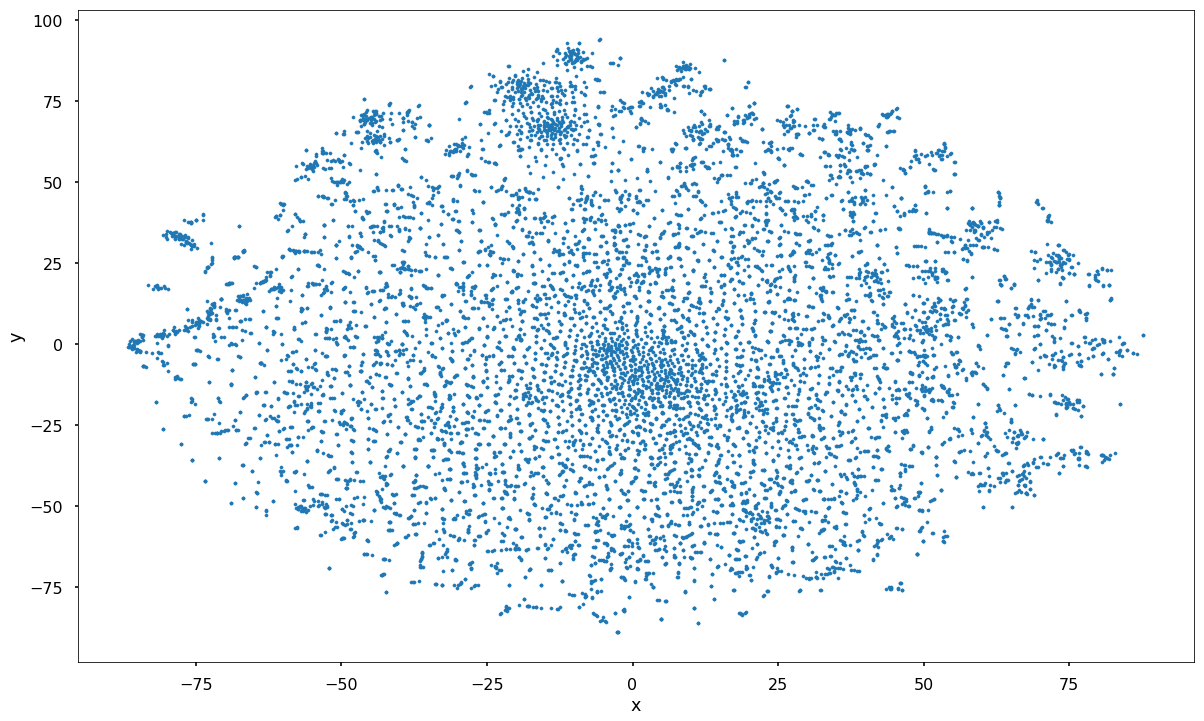

In [101]:
# Plot word vectors on 2D graph

sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.show()

In [102]:
def plot_region(x_bounds, y_bounds):
    
    '''Zooms into a region to see similarity of different words'''
    
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
     
    ax = slice.plot.scatter('x', 'y', s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

    return

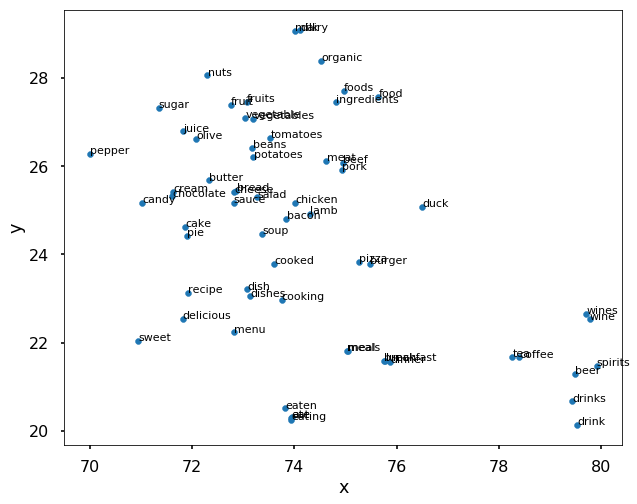

In [112]:
plot_region(x_bounds=(70, 80), y_bounds=(20, 30))

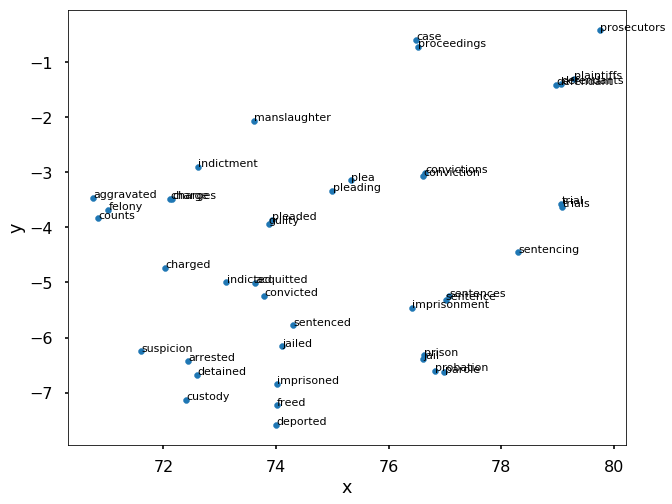

In [122]:
plot_region(x_bounds=(70, 80), y_bounds=(-10, 0))

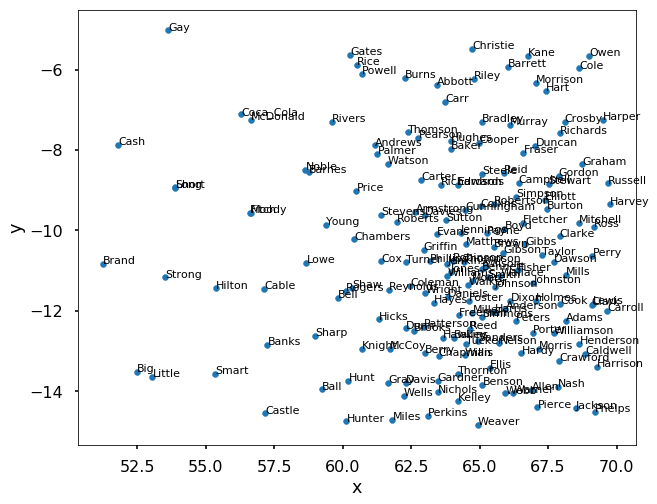

In [676]:
plot_region(x_bounds=(50, 70), y_bounds=(-15, -5))

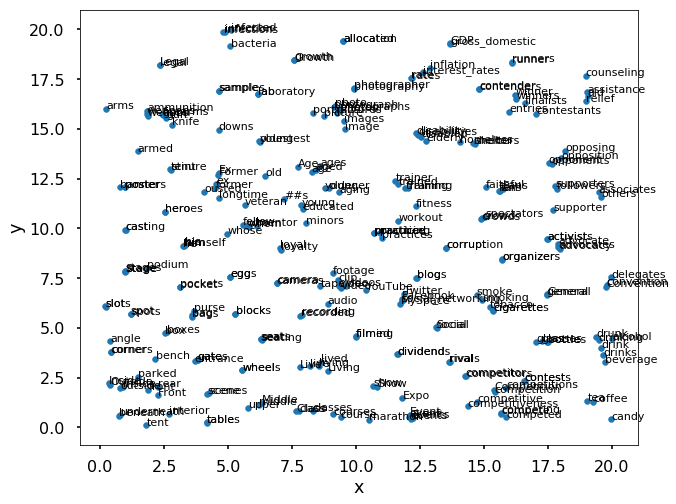

In [680]:
plot_region(x_bounds=(0, 20), y_bounds=(0, 20))